In [10]:
import logging

import numpy as np
import optimistix as optx
from atmodeller import (
    InteriorAtmosphere,
    Planet,
    Species,
    SpeciesCollection,
    debug_logger,
    earth_oceans_to_hydrogen_mass,
    SolverParameters,
)
from atmodeller.eos import get_eos_models
from atmodeller.solubility import get_solubility_models
from atmodeller.thermodata import IronWustiteBuffer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm

from scipy.interpolate import interp1d
import os

from matplotlib.ticker import ScalarFormatter

formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
formatter.set_useOffset(False)
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

logger = debug_logger()
logger.setLevel(logging.INFO)

# For more output use DEBUG
# logger.setLevel(logging.DEBUG)

In [11]:
number_of_realisations = 10
surface_temperature = 2000  # K -> take another temperature, the one aligning with mbe, up to 2-3k kelvin https://link.springer.com/article/10.1007/s11214-020-00660-3
# For simulations with fixed mass and surface radius:
planet_mass = 8e25 #13.4 earth masses for inside boundary (90% somewhat, could be less, reask)
surface_radius = 2.5559e7  # Lindal et al -> Can be discussed, radius of magma envelope boundary -> reduce and deal with incostitent between rocky and ice planets
#will iterate over later, take for now 0.8 r_U (I find results of 0.4-0.9). r_U = 2.5559e7 https://link.springer.com/article/10.1007/s11214-020-00660-3

In [12]:
R_earth = 6371000
M_earth = 5.972e24
R_uranus = 3.979310 * R_earth #Nettelman 2013 U1
number_of_realisations = 50
surface_temperature = 5000  # Based On Nettelman 2013U1
planet_mass = 14.5322753*M_earth 

#defining now for different regions
core_mass = 0.5984897*M_earth #Nettelman 2013 U1
core_radius = 0.700034*R_earth
core_temperature = 6083.6 
#core_mass = 0.11*planet_mass  #Based on #https://arxiv.org/pdf/2412.06010
#r_core = 0.2*R_uranus  # Nettelman 2013

#now for MEB, based on Kaustub mass-relation for rocky planets R_P = 1.02*M_earth^0.252 = 2 R_earth
MBE_radius = 2*R_earth 
MBE_temperature = 4500 # https://www.pnas.org/doi/10.1073/pnas.2403981121
MBE_mass = 0.36*planet_mass # https://www.pnas.org/doi/10.1073/pnas.2403981121

#region of full mantle, boundary between inner and outer envelope
boundary_radius = 0.772*R_uranus #Nettelman 2013 U1
boundary_temperature = 2338.8
boundary_mass = 0.913*planet_mass #Nettelman 2013 U1


mantle_melt_fraction = 1.0  # 0.1 -> we will iterate 
planet_mass = boundary_mass

RANDOM_SEED = 0

np.random.seed(RANDOM_SEED)

In [13]:
H_masspercent_lodders09: float = 73.9
He_masspercent_lodders09: float = 24.69
C_masspercent_lodders09: float = 0.22
N_masspercent_lodders09: float = 0.07
O_masspercent_lodders09: float = 0.63
Si_masspercent_lodders09: float = 0.07
Mg_masspercent_lodders09: float = 0.06

H_logN: float = 12
He_logN: float = 10.93
C_logN: float = 8.39
N_logN: float = 7.86
O_logN: float = 8.73
Si_logN: float = 7.53
Mg_logN: float = 7.54 

In [14]:
#SiO2 for primitive composition of Earth
SiO2_mantlemasspercent_palme14: float = 45.4
total_mantlemasspercent_palme14: float = 98.41
core_mass_fraction: float = 0.327  # typical values used are between 0.325 - 0.33
Si_massfraction_palme14: float = round(
    SiO2_mantlemasspercent_palme14
    / total_mantlemasspercent_palme14
    * (1 - core_mass_fraction)
    / (28.0855 + 2 * 15.999)
    * 28.0855,
    3,
)

O_massfraction_palme141: float = Si_massfraction_palme14 / 28.0855 * 2 * 15.999

MgO_mantlemasspercent_palme14: float = 36.77
Mg_massfraction_palme14: float = round(
    MgO_mantlemasspercent_palme14
    / total_mantlemasspercent_palme14
    * (1 - core_mass_fraction)
    / (24.305 + 15.999)
    * 24.305,
    3,
)

O_massfraction_palme142: float = Si_massfraction_palme14 / 24.305 * 15.999
O_massfraction_palme14 = O_massfraction_palme141 + O_massfraction_palme142

In [15]:
eos_models = get_eos_models()
sol_models = get_solubility_models()

H2O_g = Species.create_gas("H2O")
H2O_gs = Species.create_gas("H2O", solubility=sol_models["H2O_peridotite_sossi23"])
H2O_rgs = Species.create_gas(
    "H2O",
    activity=eos_models["H2O_cork_holland98"],
    solubility=sol_models["H2O_peridotite_sossi23"],
)

H2_g = Species.create_gas("H2")
H2_gs = Species.create_gas("H2", solubility=sol_models["H2_basalt_hirschmann12"])
H2_rgs = Species.create_gas(
    "H2", activity=eos_models["H2_chabrier21"], solubility=sol_models["H2_basalt_hirschmann12"]
)

O2_g = Species.create_gas("O2")
O2_rg = Species.create_gas("O2", activity=eos_models["O2_cs_shi92"])

OSi_g = Species.create_gas("OSi")
OSi_rg = Species.create_gas("OSi", activity=eos_models["OSi_rk49_connolly16"])

H4Si_g = Species.create_gas("H4Si")
H4Si_rg = Species.create_gas("H4Si", activity=eos_models["H4Si_wang18"])

O2Si_l = Species.create_condensed("O2Si", state="l")
O2Si_bqz = Species.create_condensed("O2Si", state="bqz")

CO2_g = Species.create_gas("CO2")
CO2_gs = Species.create_gas("CO2", solubility=sol_models["CO2_basalt_dixon95"])
CO2_rgs = Species.create_gas(
    "CO2", solubility=sol_models["CO2_basalt_dixon95"], activity=eos_models["CO2_cs_shi92"]
)

CO_g = Species.create_gas("CO")
CO_gs = Species.create_gas("CO", solubility=sol_models["CO_basalt_yoshioka19"])
CO_rgs = Species.create_gas(
    "CO", solubility=sol_models["CO_basalt_yoshioka19"], activity=eos_models["CO_cs_shi92"]
)

CH4_g = Species.create_gas("CH4")
CH4_gs = Species.create_gas("CH4", solubility=sol_models["CH4_basalt_ardia13"])
CH4_rgs = Species.create_gas(
    "CH4", solubility=sol_models["CH4_basalt_ardia13"], activity=eos_models["CH4_cs_shi92"]
)

N2_g = Species.create_gas("N2")
N2_gs = Species.create_gas("N2", solubility=sol_models["N2_basalt_libourel03"])
N2_rgs = Species.create_gas(
    "N2", solubility=sol_models["N2_basalt_libourel03"], activity=eos_models["N2_cs_saxena87"]
)

NH3_g = Species.create_gas("NH3")
NH3_rg = Species.create_gas("H3N", activity=eos_models["H3N_rk49_reid87"])

He_g = Species.create_gas("He")
He_gs = Species.create_gas("He", solubility=sol_models["He_basalt_jambon86"])
He_rgs = Species.create_gas(
    "He", solubility=sol_models["He_basalt_jambon86"], activity=eos_models["He_chabrier21"]
)

Mg_g = Species.create_gas("Mg")
#Mg_gs = Species.create_gas("He", solubility=sol_models["He_basalt_jambon86"])
#Mg_rgs = Species.create_gas(
#    "He", solubility=sol_models["He_basalt_jambon86"], activity=eos_models["He_chabrier21"]
#)

MgO_l = Species.create_condensed("MgO", state="l")
MgO_cr = Species.create_condensed("MgO", state="cr")
MgH_g = Species.create_gas("MgH")
MgOH_g = Species.create_gas("MgOH")

species_HHeCNOSi_magma_nosol_ideal = SpeciesCollection(
    (H2O_g, H2_g, O2_g, OSi_g, H4Si_g, O2Si_l, CO2_g, CO_g, CH4_g, N2_g, NH3_g, He_g, Mg_g, MgO_l, MgH_g, MgOH_g)
)
species_HHeCNOSi_magma_sol_ideal = SpeciesCollection(
    (H2O_gs, H2_gs, O2_g, OSi_g, H4Si_g, O2Si_l, CO2_gs, CO_gs, CH4_gs, N2_gs, NH3_g, He_gs, Mg_g, MgO_l, MgH_g, MgOH_g)
)
species_HHeCNOSi_magma_sol_real = SpeciesCollection(
    (
        H2O_rgs,
        H2_rgs,
        O2_rg,
        OSi_rg,
        H4Si_rg,
        O2Si_l,
        CO2_rgs,
        CO_rgs,
        CH4_rgs,
        N2_rgs,
        NH3_rg,
        He_rgs,
        Mg_g, 
        MgO_l,
        MgH_g,
        MgOH_g
    )
)
#MgH Magnesium Hydride
#MgOH Magnesium Hydroxide -> ideal gas law 
#Plot condensed moles for example for Silicon
#mass balance, take mass constraints, take atmospheric mass/moles+ take condensed mass/moles + take dissolved mass/moles
#plot envelope mass fraction, envelope mass/planet mass, Helled, what do they call the volatile layer. 
#temperature-pressure profile at 1 Myr or 10 Myr
#Ravit Helled 2011-2013

In [16]:
temperature = np.linspace(2000,3000,100)
hmps = np.logspace(-1, 0.7, num=10)  # wt% Hn can go higher for exploration, maybe even 50)

In [17]:
color_tot = "black"
color_H2 = "orange"
color_H2O = "blue"
color_SiH4 = "red"
color_SiO = "brown"
color_O2 = "limegreen"
color_CO2 = "cyan"
color_CO = "magenta"
color_CH4 = "purple"
color_N2 = "green"
color_NH3 = "pink"
color_MgO = "darkred"
color_He = "gray"
color_H = "orange"
color_C = "cyan"
color_N = "green"
color_O = "blue"
color_Si = "red"
color_Mg = "lime"
color_MgH2 = "gold"
color_MgH = "teal"
color_MgOH = "indigo"

[10:39:58 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMgO_g: IdealGas, NoSolubility')
[10:39:58 - atmodeller.classes             - INFO     ] - reactions = {0: '1.0 H2_g + 1.0 CO2_g = 1.0 H2O_g + 1.0 CO_g',
 1: '4.0 H2_g + 1.0 CO2_g = 2.0 H2O_g + 1.0 CH4_g',
 2: '4.0 H2_g + 1.0 O2Si_l = 2.0 H2O_g + 1.0 H4Si_g',
 3: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 4: '2.0 H2O_g = 2.0 H2_g + 1.0 O2_g',
 5: '1.0 H2_g + 1.0 O2Si_l = 1.0 H2O_g + 1.0 OSi_g',
 6: '1.0 H2O_g + 1.0 Mg_g = 

0.1


[10:40:02 - atmodeller.output              - INFO     ] - Writing output to excel
[10:40:02 - atmodeller.output              - INFO     ] - Computing to_dataframes output
[10:40:02 - atmodeller.output              - INFO     ] - Computing asdict output
[10:40:06 - atmodeller.output              - INFO     ] - Output written to HHeCNOSi_magma_nosol_ideal.xlsx
[10:40:06 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, SolubilityPowerLaw', 'H2_g: IdealGas, SolubilityPowerLawLog10', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, _CO2_basalt_dixon95', 'CO_g: IdealGas, _CO_basalt_yoshioka19', 'CH4_g: IdealGas, _CH4_basalt_ardia13', 'N2_g: IdealGas, _N2_basalt_libourel03', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, SolubilityPowerLaw', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMg

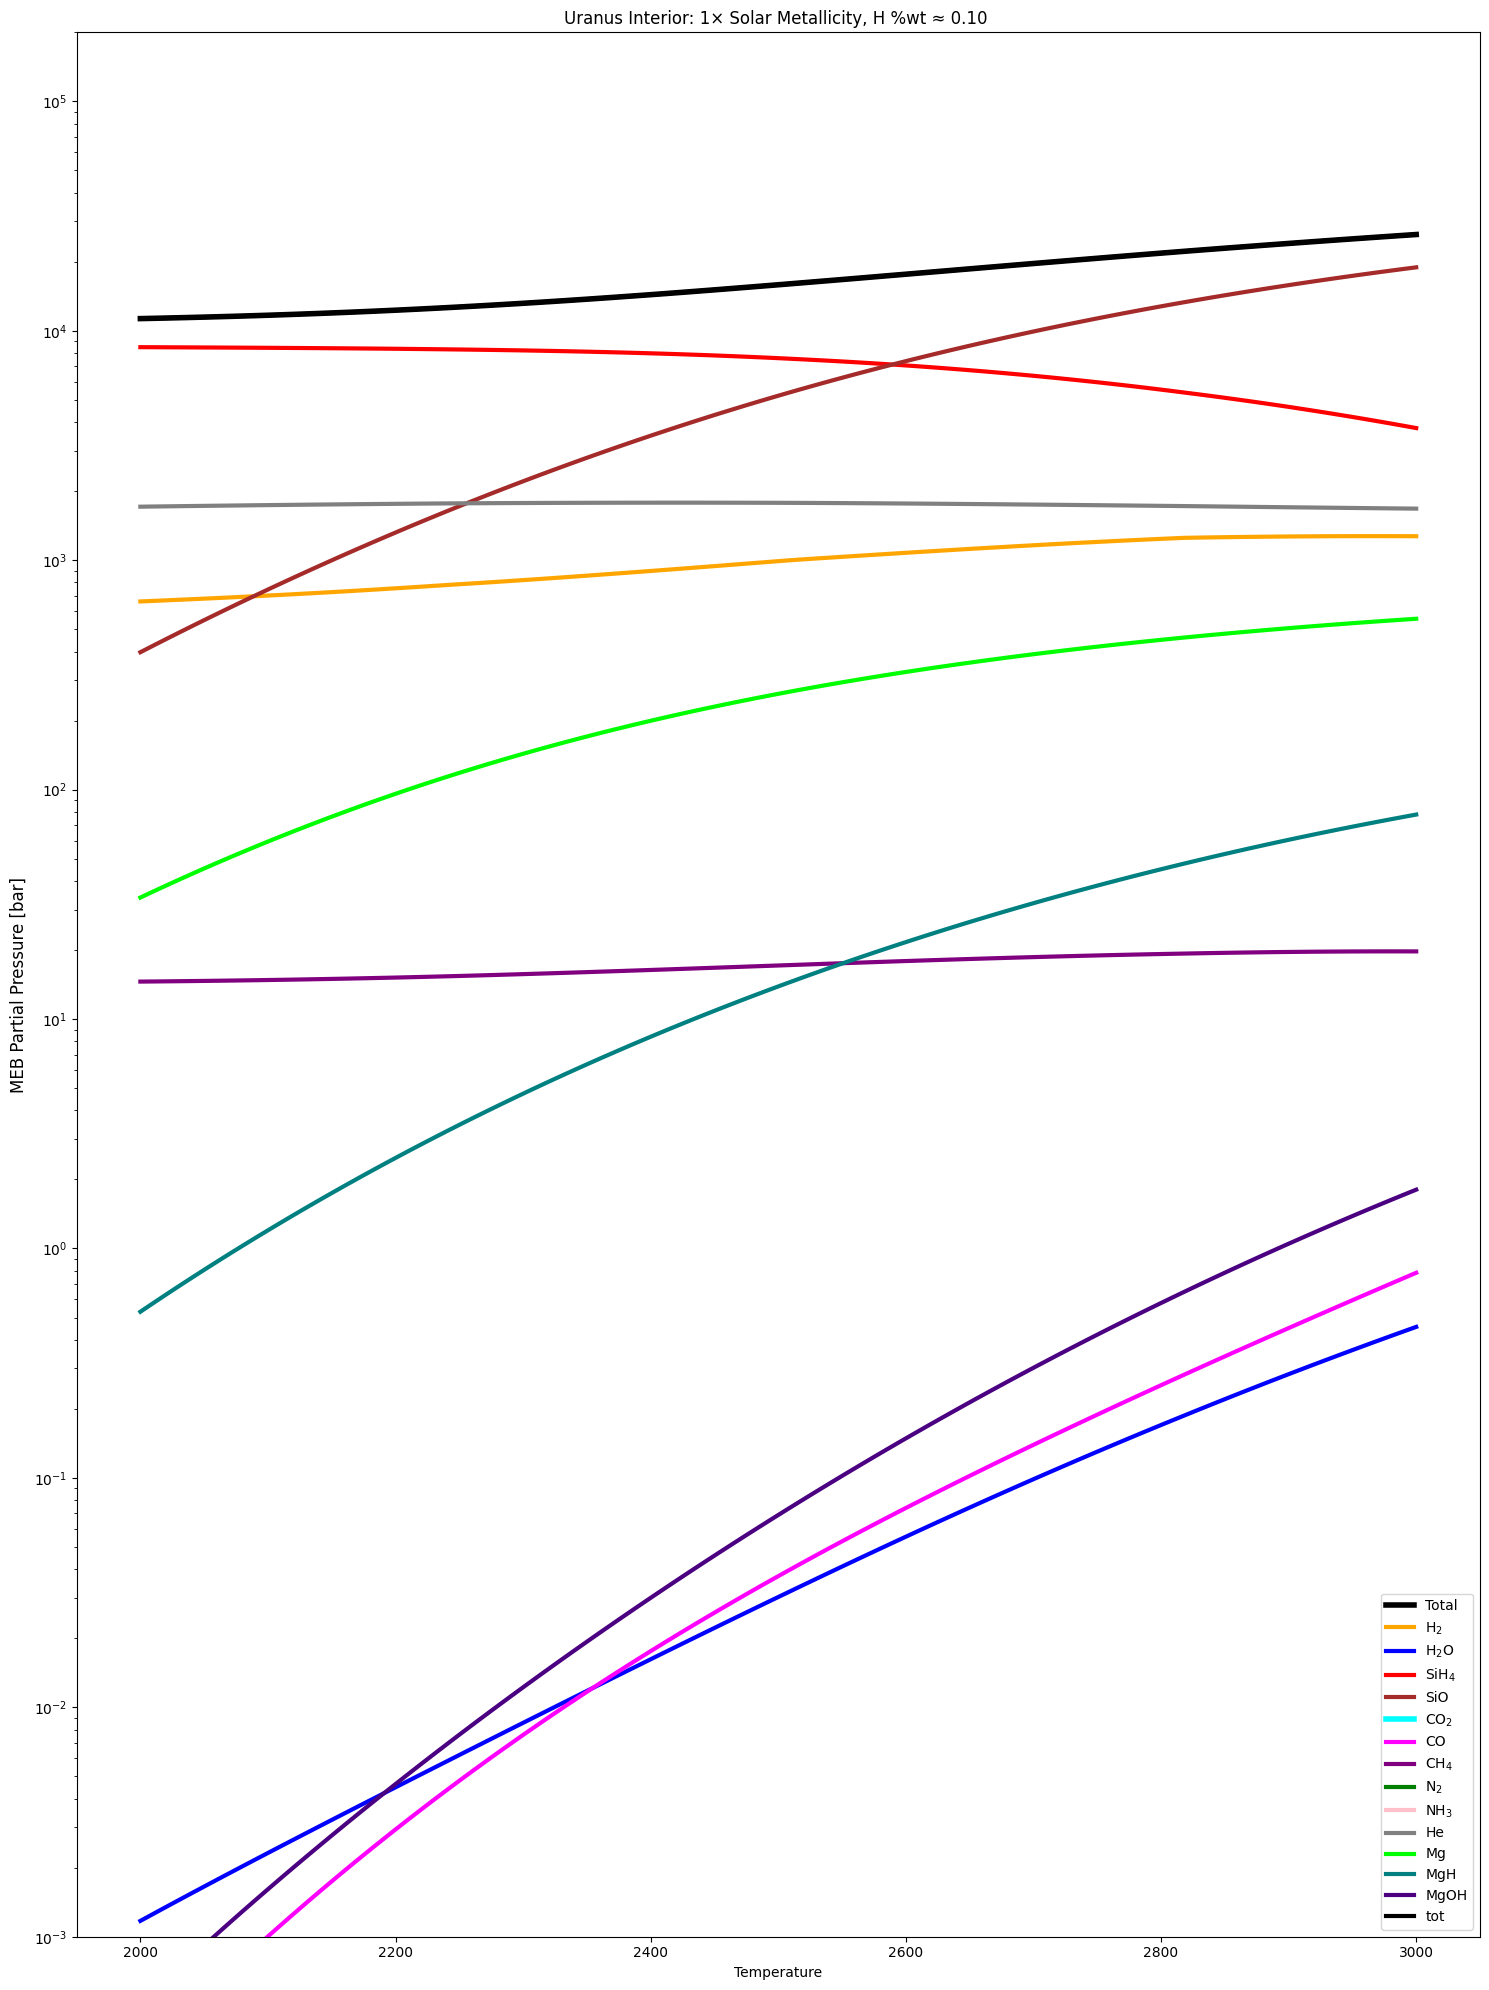

[10:40:31 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMgO_g: IdealGas, NoSolubility')
[10:40:31 - atmodeller.classes             - INFO     ] - reactions = {0: '1.0 H2_g + 1.0 CO2_g = 1.0 H2O_g + 1.0 CO_g',
 1: '4.0 H2_g + 1.0 CO2_g = 2.0 H2O_g + 1.0 CH4_g',
 2: '4.0 H2_g + 1.0 O2Si_l = 2.0 H2O_g + 1.0 H4Si_g',
 3: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 4: '2.0 H2O_g = 2.0 H2_g + 1.0 O2_g',
 5: '1.0 H2_g + 1.0 O2Si_l = 1.0 H2O_g + 1.0 OSi_g',
 6: '1.0 H2O_g + 1.0 Mg_g = 

0.15448591479026755


[10:40:32 - atmodeller.classes             - WARNING  ] - 1 model(s) failed to converge on the first attempt
[10:40:32 - atmodeller.classes             - WARNING  ] - But don't panic! This can happen when starting from a poor initial guess.
[10:40:32 - atmodeller.classes             - WARNING  ] - Launching multistart (maximum 10 attempts)
[10:40:32 - atmodeller.classes             - WARNING  ] - Attempting to solve the 1 models(s) that initially failed
[10:40:32 - atmodeller.classes             - INFO     ] - Multistart with species' stability (TAU_MAX= 1.0e-03, TAU= 1.0e-25, TAU_NUM= 2)
[10:40:39 - atmodeller.classes             - INFO     ] - Multistart complete with 1 total attempt(s)
[10:40:39 - atmodeller.classes             - INFO     ] - Multistart, max attempts: 1, model count: 100 (100.00%)
[10:40:39 - atmodeller.classes             - INFO     ] - Solve complete: 100 (100.00%) successful model(s)
[10:40:39 - atmodeller.classes             - INFO     ] - Solver steps (max) = 1

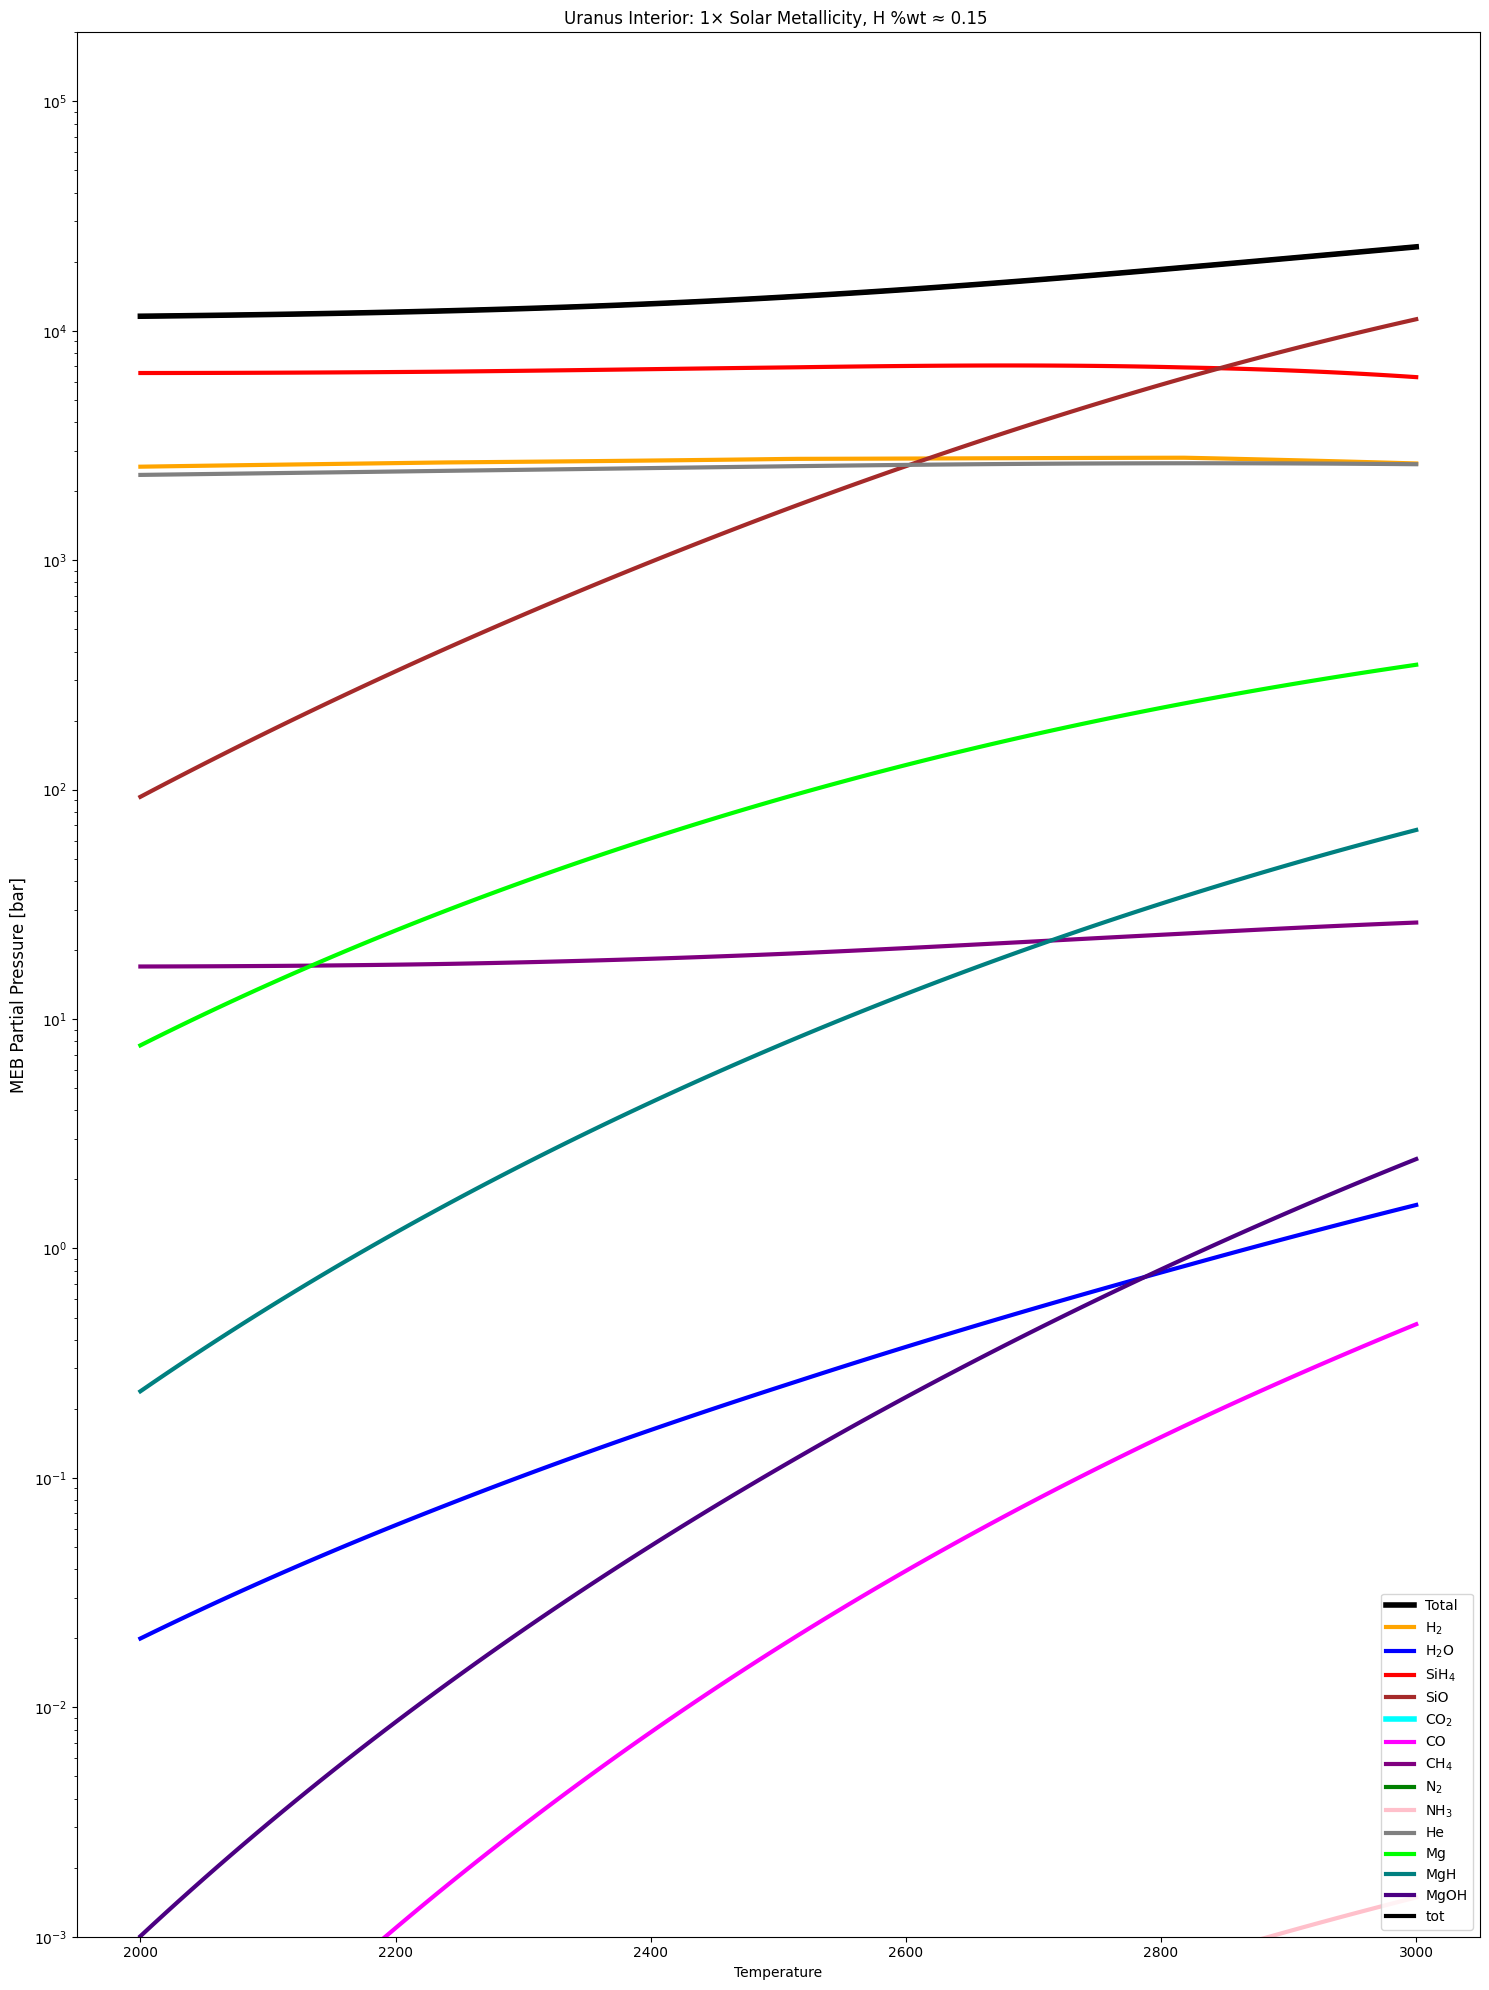

[10:41:13 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMgO_g: IdealGas, NoSolubility')
[10:41:13 - atmodeller.classes             - INFO     ] - reactions = {0: '1.0 H2_g + 1.0 CO2_g = 1.0 H2O_g + 1.0 CO_g',
 1: '4.0 H2_g + 1.0 CO2_g = 2.0 H2O_g + 1.0 CH4_g',
 2: '4.0 H2_g + 1.0 O2Si_l = 2.0 H2O_g + 1.0 H4Si_g',
 3: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 4: '2.0 H2O_g = 2.0 H2_g + 1.0 O2_g',
 5: '1.0 H2_g + 1.0 O2Si_l = 1.0 H2O_g + 1.0 OSi_g',
 6: '1.0 H2O_g + 1.0 Mg_g = 

0.2386589786858581


[10:41:14 - atmodeller.classes             - WARNING  ] - 4 model(s) failed to converge on the first attempt
[10:41:14 - atmodeller.classes             - WARNING  ] - But don't panic! This can happen when starting from a poor initial guess.
[10:41:14 - atmodeller.classes             - WARNING  ] - Launching multistart (maximum 10 attempts)
[10:41:14 - atmodeller.classes             - WARNING  ] - Attempting to solve the 4 models(s) that initially failed
[10:41:14 - atmodeller.classes             - INFO     ] - Multistart with species' stability (TAU_MAX= 1.0e-03, TAU= 1.0e-25, TAU_NUM= 2)
[10:41:20 - atmodeller.classes             - INFO     ] - Multistart complete with 1 total attempt(s)
[10:41:20 - atmodeller.classes             - INFO     ] - Multistart, max attempts: 1, model count: 100 (100.00%)
[10:41:20 - atmodeller.classes             - INFO     ] - Solve complete: 100 (100.00%) successful model(s)
[10:41:20 - atmodeller.classes             - INFO     ] - Solver steps (max) = 1

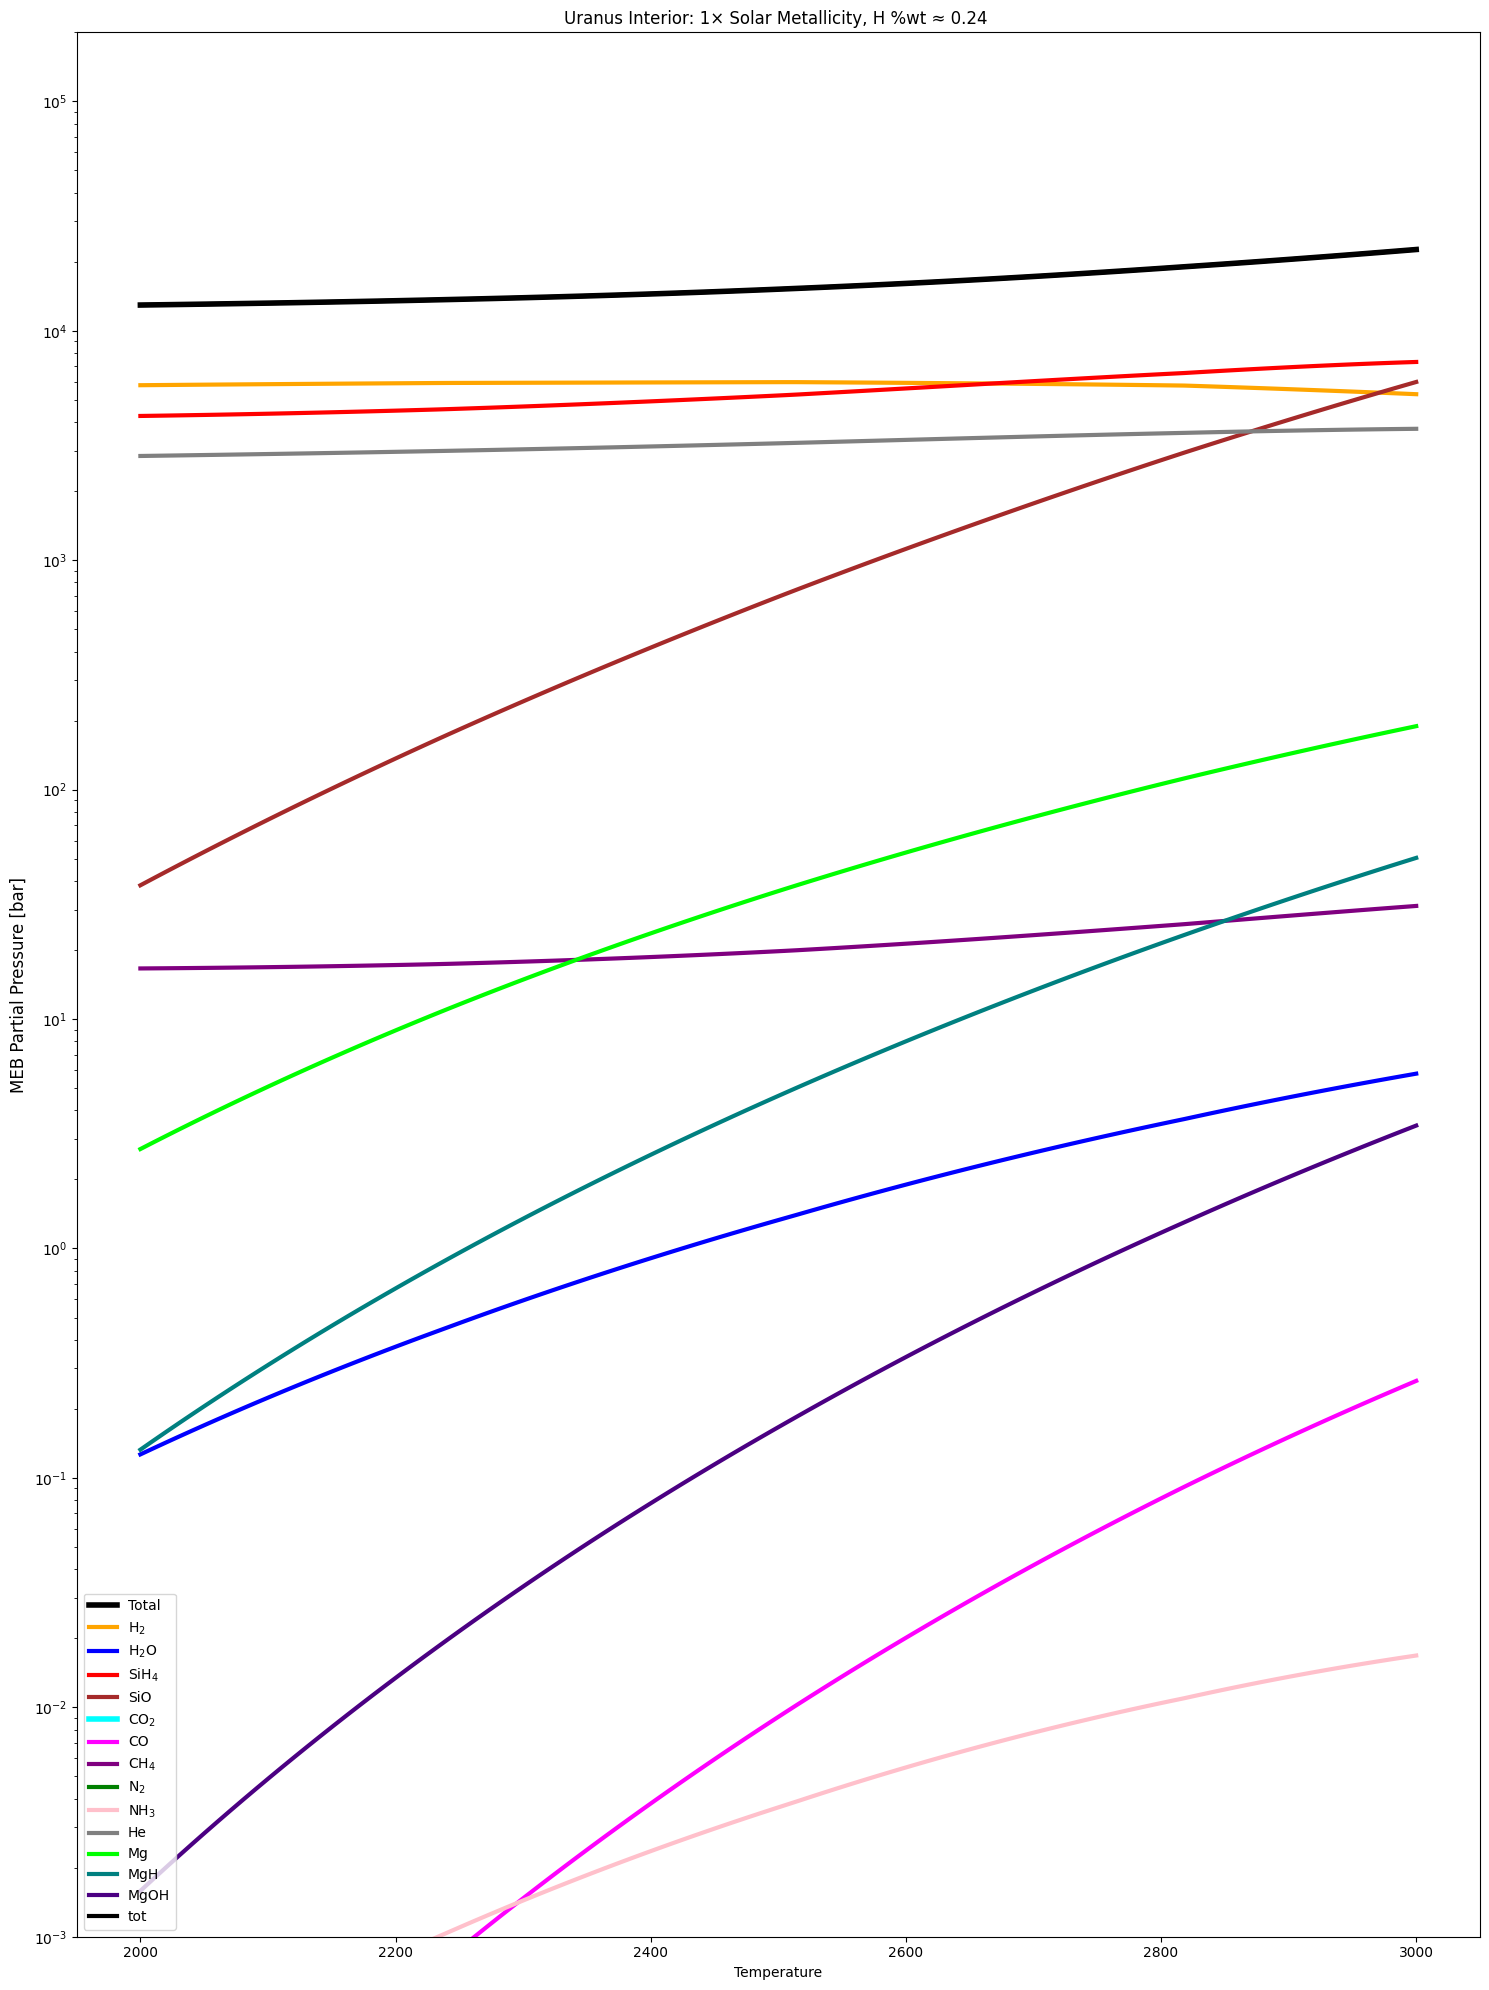

[10:41:52 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMgO_g: IdealGas, NoSolubility')
[10:41:52 - atmodeller.classes             - INFO     ] - reactions = {0: '1.0 H2_g + 1.0 CO2_g = 1.0 H2O_g + 1.0 CO_g',
 1: '4.0 H2_g + 1.0 CO2_g = 2.0 H2O_g + 1.0 CH4_g',
 2: '4.0 H2_g + 1.0 O2Si_l = 2.0 H2O_g + 1.0 H4Si_g',
 3: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 4: '2.0 H2O_g = 2.0 H2_g + 1.0 O2_g',
 5: '1.0 H2_g + 1.0 O2Si_l = 1.0 H2O_g + 1.0 OSi_g',
 6: '1.0 H2O_g + 1.0 Mg_g = 

0.3686945064519575


[10:41:54 - atmodeller.output              - INFO     ] - Writing output to excel
[10:41:54 - atmodeller.output              - INFO     ] - Computing to_dataframes output
[10:41:54 - atmodeller.output              - INFO     ] - Computing asdict output
[10:41:58 - atmodeller.output              - INFO     ] - Output written to HHeCNOSi_magma_nosol_ideal.xlsx
[10:41:58 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, SolubilityPowerLaw', 'H2_g: IdealGas, SolubilityPowerLawLog10', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, _CO2_basalt_dixon95', 'CO_g: IdealGas, _CO_basalt_yoshioka19', 'CH4_g: IdealGas, _CH4_basalt_ardia13', 'N2_g: IdealGas, _N2_basalt_libourel03', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, SolubilityPowerLaw', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMg

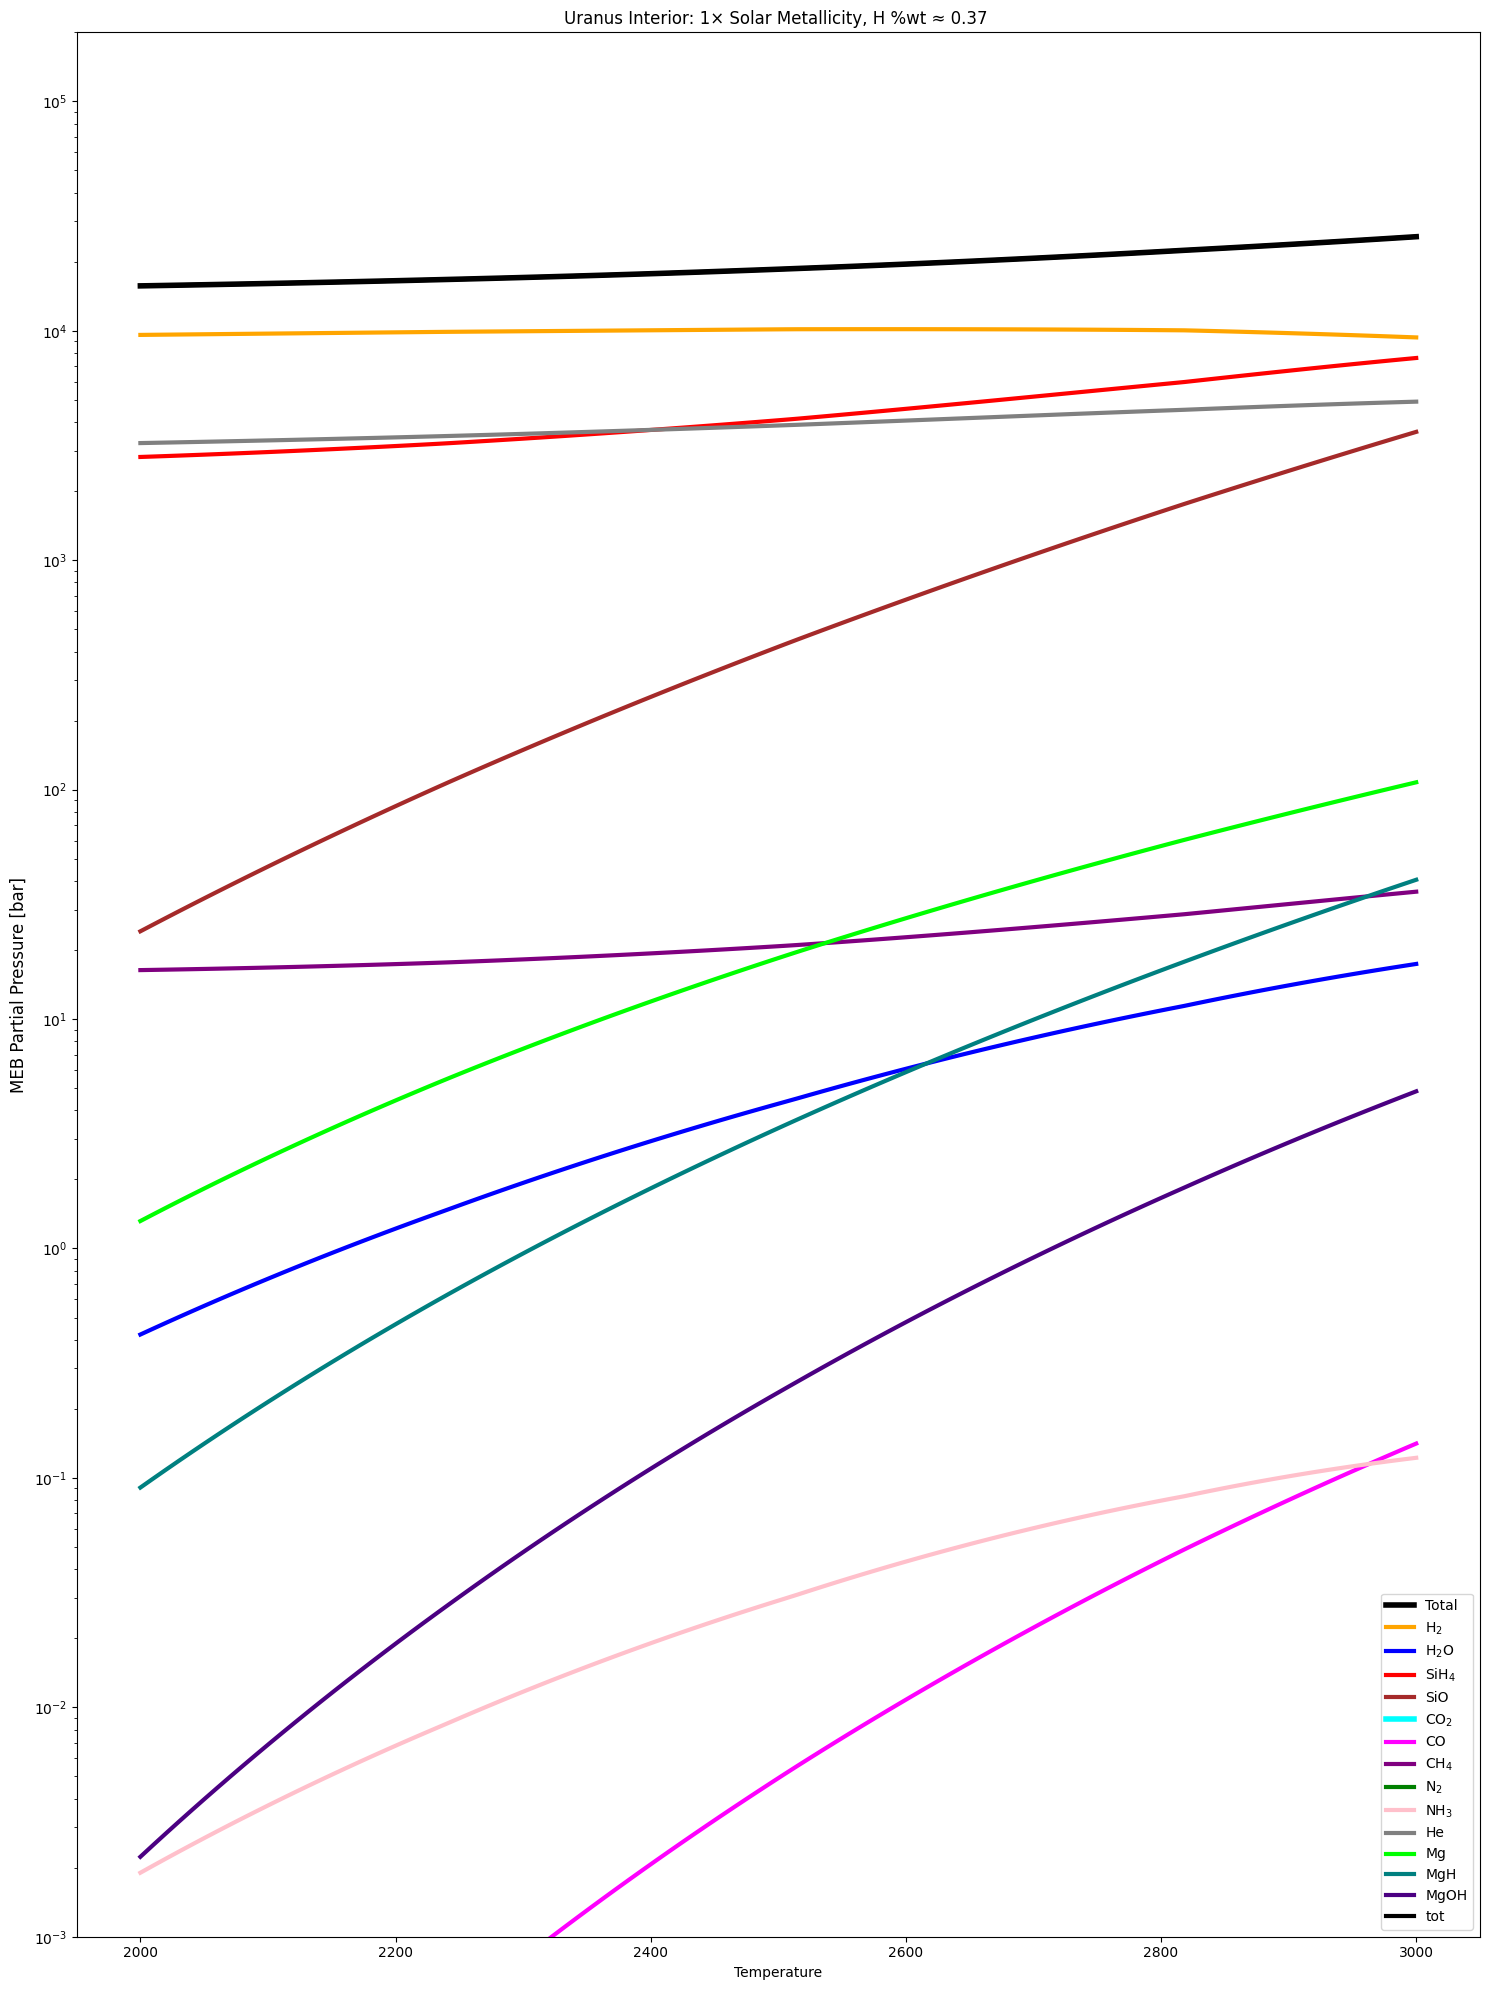

[10:42:23 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMgO_g: IdealGas, NoSolubility')
[10:42:23 - atmodeller.classes             - INFO     ] - reactions = {0: '1.0 H2_g + 1.0 CO2_g = 1.0 H2O_g + 1.0 CO_g',
 1: '4.0 H2_g + 1.0 CO2_g = 2.0 H2O_g + 1.0 CH4_g',
 2: '4.0 H2_g + 1.0 O2Si_l = 2.0 H2O_g + 1.0 H4Si_g',
 3: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 4: '2.0 H2O_g = 2.0 H2_g + 1.0 O2_g',
 5: '1.0 H2_g + 1.0 O2Si_l = 1.0 H2O_g + 1.0 OSi_g',
 6: '1.0 H2O_g + 1.0 Mg_g = 

0.5695810810737686


[10:42:25 - atmodeller.output              - INFO     ] - Writing output to excel
[10:42:25 - atmodeller.output              - INFO     ] - Computing to_dataframes output
[10:42:25 - atmodeller.output              - INFO     ] - Computing asdict output
[10:42:31 - atmodeller.output              - INFO     ] - Output written to HHeCNOSi_magma_nosol_ideal.xlsx
[10:42:31 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, SolubilityPowerLaw', 'H2_g: IdealGas, SolubilityPowerLawLog10', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, _CO2_basalt_dixon95', 'CO_g: IdealGas, _CO_basalt_yoshioka19', 'CH4_g: IdealGas, _CH4_basalt_ardia13', 'N2_g: IdealGas, _N2_basalt_libourel03', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, SolubilityPowerLaw', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMg

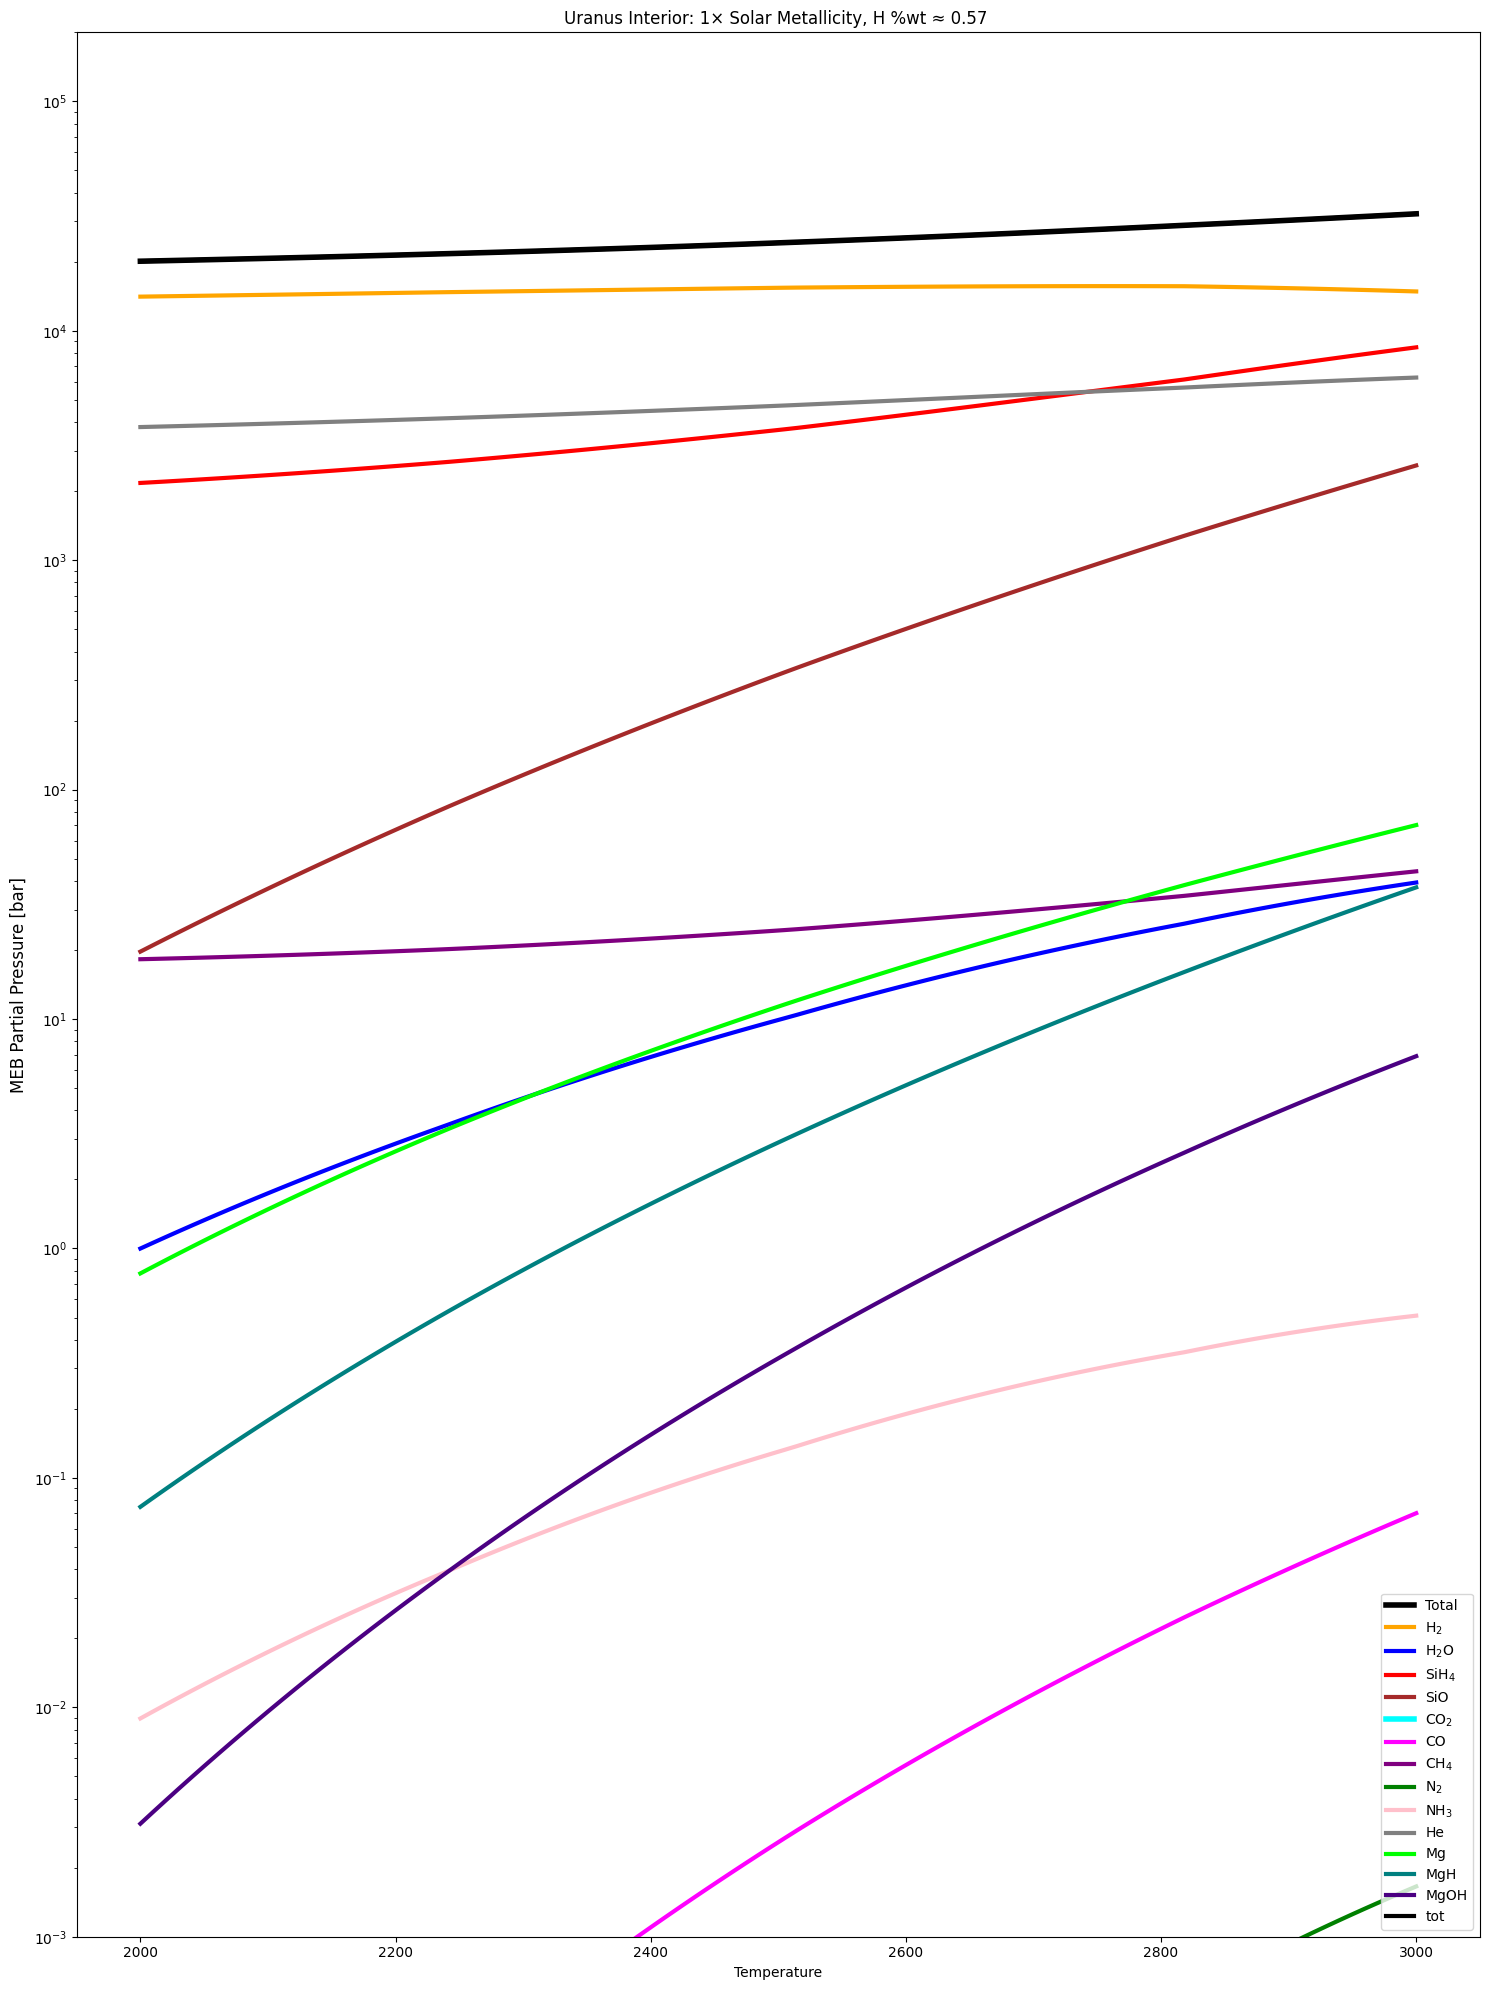

[10:42:56 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMgO_g: IdealGas, NoSolubility')
[10:42:56 - atmodeller.classes             - INFO     ] - reactions = {0: '1.0 H2_g + 1.0 CO2_g = 1.0 H2O_g + 1.0 CO_g',
 1: '4.0 H2_g + 1.0 CO2_g = 2.0 H2O_g + 1.0 CH4_g',
 2: '4.0 H2_g + 1.0 O2Si_l = 2.0 H2O_g + 1.0 H4Si_g',
 3: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 4: '2.0 H2O_g = 2.0 H2_g + 1.0 O2_g',
 5: '1.0 H2_g + 1.0 O2Si_l = 1.0 H2O_g + 1.0 OSi_g',
 6: '1.0 H2O_g + 1.0 Mg_g = 

0.8799225435691069


[10:42:57 - atmodeller.classes             - WARNING  ] - 2 model(s) failed to converge on the first attempt
[10:42:57 - atmodeller.classes             - WARNING  ] - But don't panic! This can happen when starting from a poor initial guess.
[10:42:57 - atmodeller.classes             - WARNING  ] - Launching multistart (maximum 10 attempts)
[10:42:57 - atmodeller.classes             - WARNING  ] - Attempting to solve the 2 models(s) that initially failed
[10:42:57 - atmodeller.classes             - INFO     ] - Multistart with species' stability (TAU_MAX= 1.0e-03, TAU= 1.0e-25, TAU_NUM= 2)
[10:43:03 - atmodeller.classes             - INFO     ] - Multistart complete with 2 total attempt(s)
[10:43:03 - atmodeller.classes             - INFO     ] - Multistart, max attempts: 1, model count: 99 (99.00%)
[10:43:03 - atmodeller.classes             - INFO     ] - Multistart, max attempts: 2, model count: 1 (1.00%)
[10:43:03 - atmodeller.classes             - INFO     ] - Solve complete: 100 (1

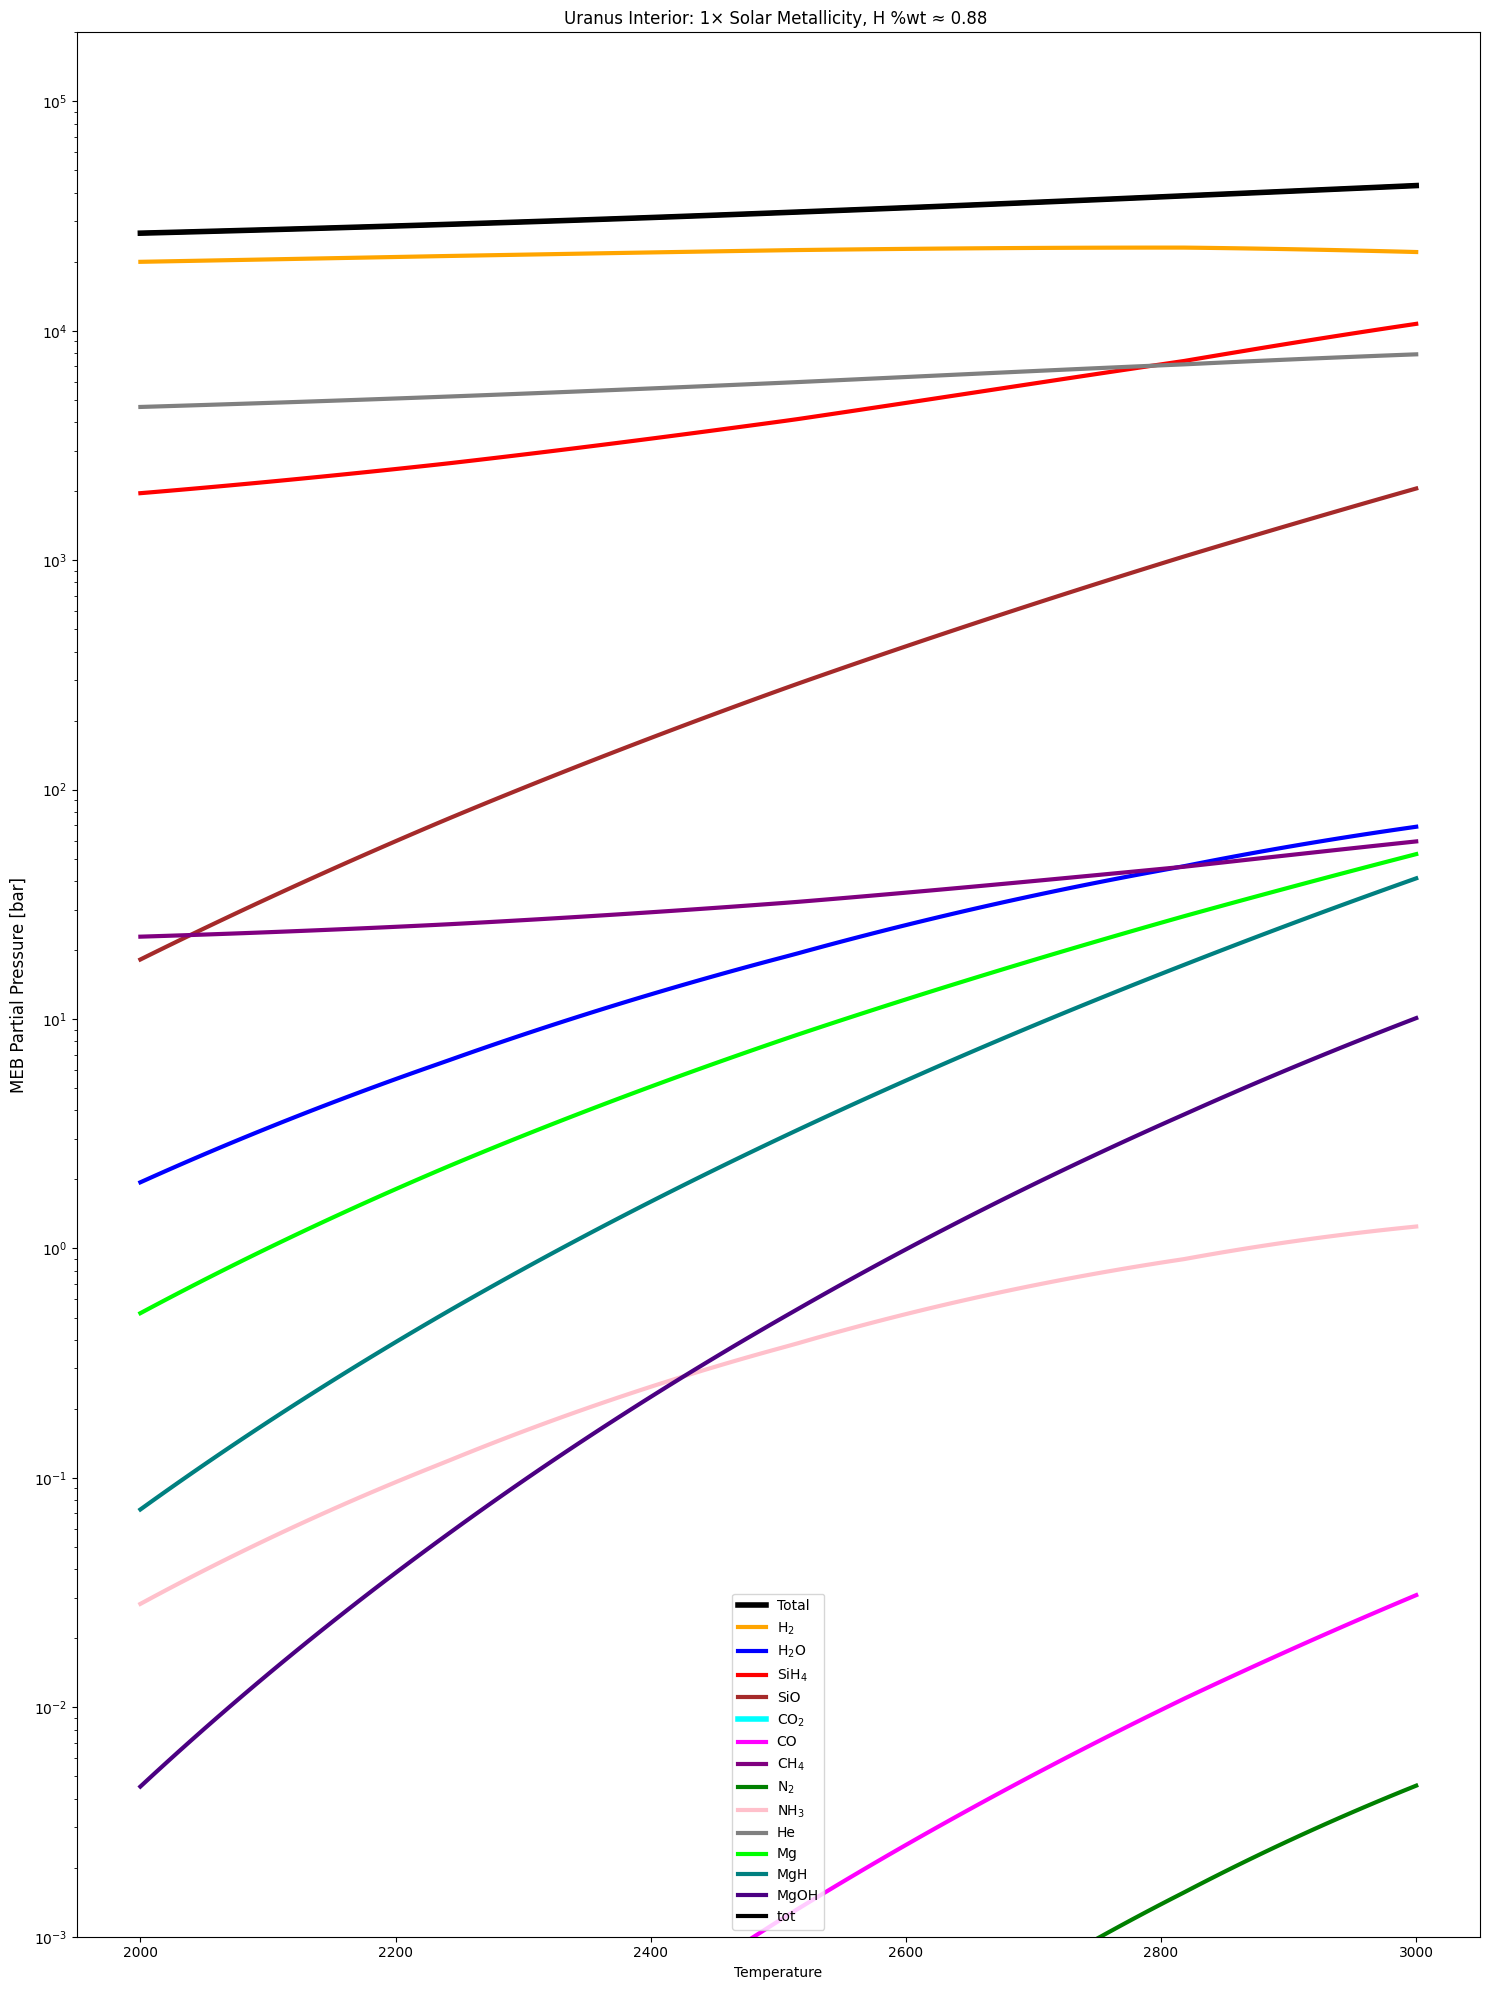

[10:43:38 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMgO_g: IdealGas, NoSolubility')
[10:43:38 - atmodeller.classes             - INFO     ] - reactions = {0: '1.0 H2_g + 1.0 CO2_g = 1.0 H2O_g + 1.0 CO_g',
 1: '4.0 H2_g + 1.0 CO2_g = 2.0 H2O_g + 1.0 CH4_g',
 2: '4.0 H2_g + 1.0 O2Si_l = 2.0 H2O_g + 1.0 H4Si_g',
 3: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 4: '2.0 H2O_g = 2.0 H2_g + 1.0 O2_g',
 5: '1.0 H2_g + 1.0 O2Si_l = 1.0 H2O_g + 1.0 OSi_g',
 6: '1.0 H2O_g + 1.0 Mg_g = 

1.3593563908785256


[10:43:39 - atmodeller.classes             - INFO     ] - Solve complete: 100 (100.00%) successful model(s)
[10:43:39 - atmodeller.classes             - INFO     ] - Solver steps (max) = 215
[10:43:41 - atmodeller.output              - INFO     ] - Writing output to excel
[10:43:41 - atmodeller.output              - INFO     ] - Computing to_dataframes output
[10:43:41 - atmodeller.output              - INFO     ] - Computing asdict output
[10:43:45 - atmodeller.output              - INFO     ] - Output written to HHeCNOSi_magma_nosol_ideal.xlsx
[10:43:45 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, SolubilityPowerLaw', 'H2_g: IdealGas, SolubilityPowerLawLog10', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, _CO2_basalt_dixon95', 'CO_g: IdealGas, _CO_basalt_yoshioka19', 'CH4_g: IdealGas, _CH4_basalt_ardia13', 'N2_g: IdealGas, _N2_basalt_libou

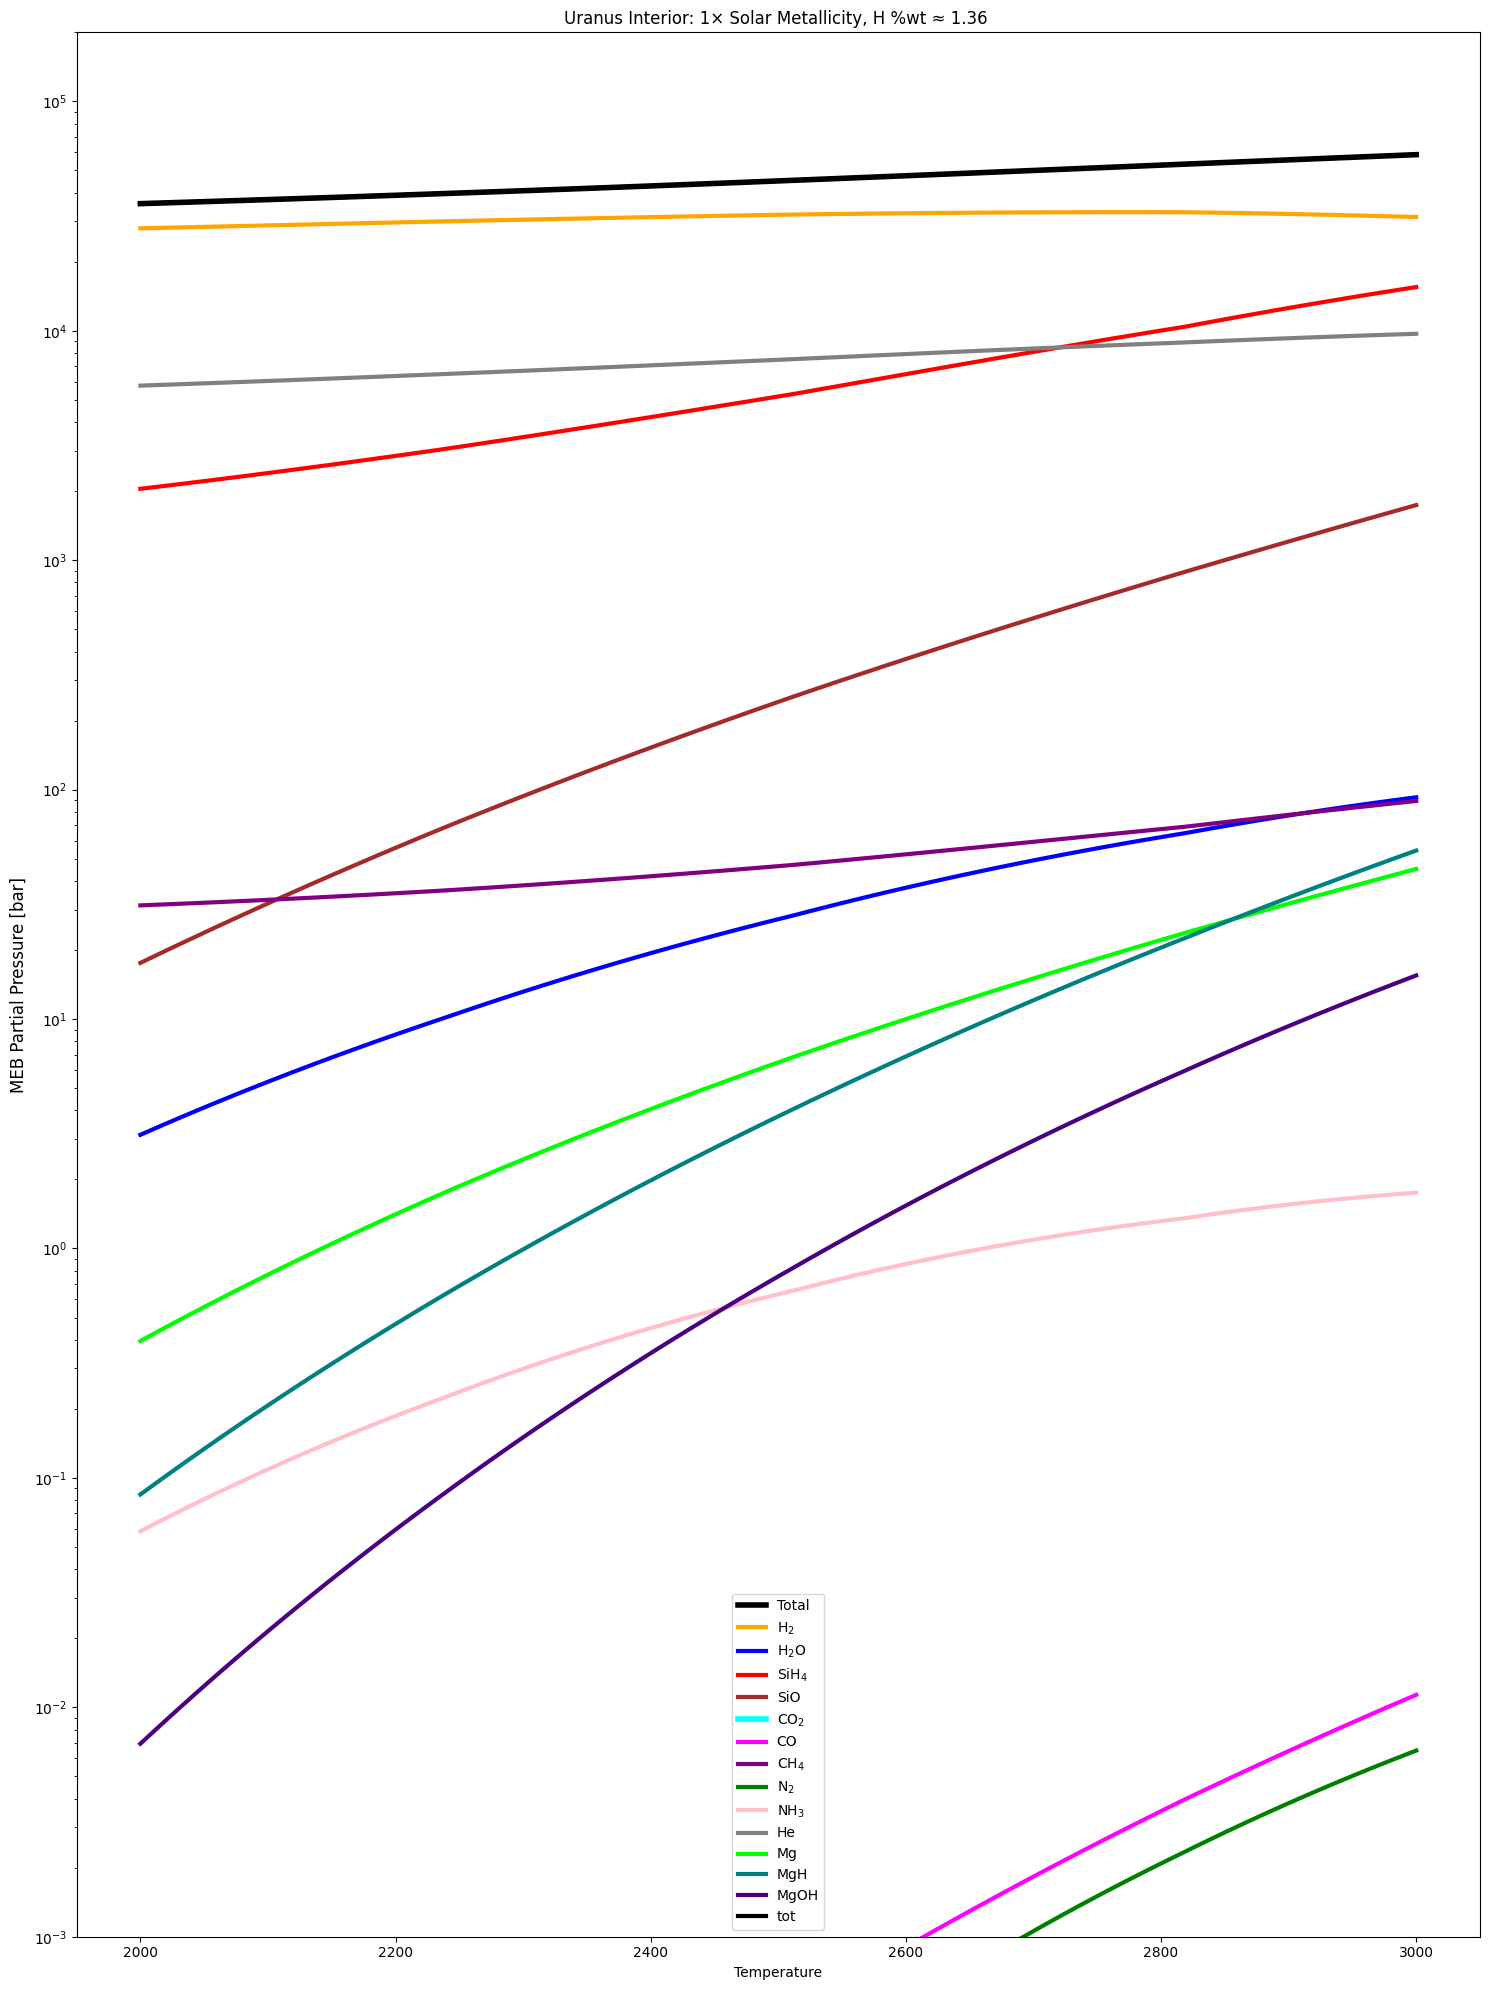

[10:44:12 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMgO_g: IdealGas, NoSolubility')
[10:44:12 - atmodeller.classes             - INFO     ] - reactions = {0: '1.0 H2_g + 1.0 CO2_g = 1.0 H2O_g + 1.0 CO_g',
 1: '4.0 H2_g + 1.0 CO2_g = 2.0 H2O_g + 1.0 CH4_g',
 2: '4.0 H2_g + 1.0 O2Si_l = 2.0 H2O_g + 1.0 H4Si_g',
 3: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 4: '2.0 H2O_g = 2.0 H2_g + 1.0 O2_g',
 5: '1.0 H2_g + 1.0 O2Si_l = 1.0 H2O_g + 1.0 OSi_g',
 6: '1.0 H2O_g + 1.0 Mg_g = 

2.100014155708655


[10:44:12 - atmodeller.classes             - INFO     ] - Solve complete: 100 (100.00%) successful model(s)
[10:44:12 - atmodeller.classes             - INFO     ] - Solver steps (max) = 87
[10:44:14 - atmodeller.output              - INFO     ] - Writing output to excel
[10:44:14 - atmodeller.output              - INFO     ] - Computing to_dataframes output
[10:44:14 - atmodeller.output              - INFO     ] - Computing asdict output
[10:44:18 - atmodeller.output              - INFO     ] - Output written to HHeCNOSi_magma_nosol_ideal.xlsx
[10:44:18 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, SolubilityPowerLaw', 'H2_g: IdealGas, SolubilityPowerLawLog10', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, _CO2_basalt_dixon95', 'CO_g: IdealGas, _CO_basalt_yoshioka19', 'CH4_g: IdealGas, _CH4_basalt_ardia13', 'N2_g: IdealGas, _N2_basalt_libour

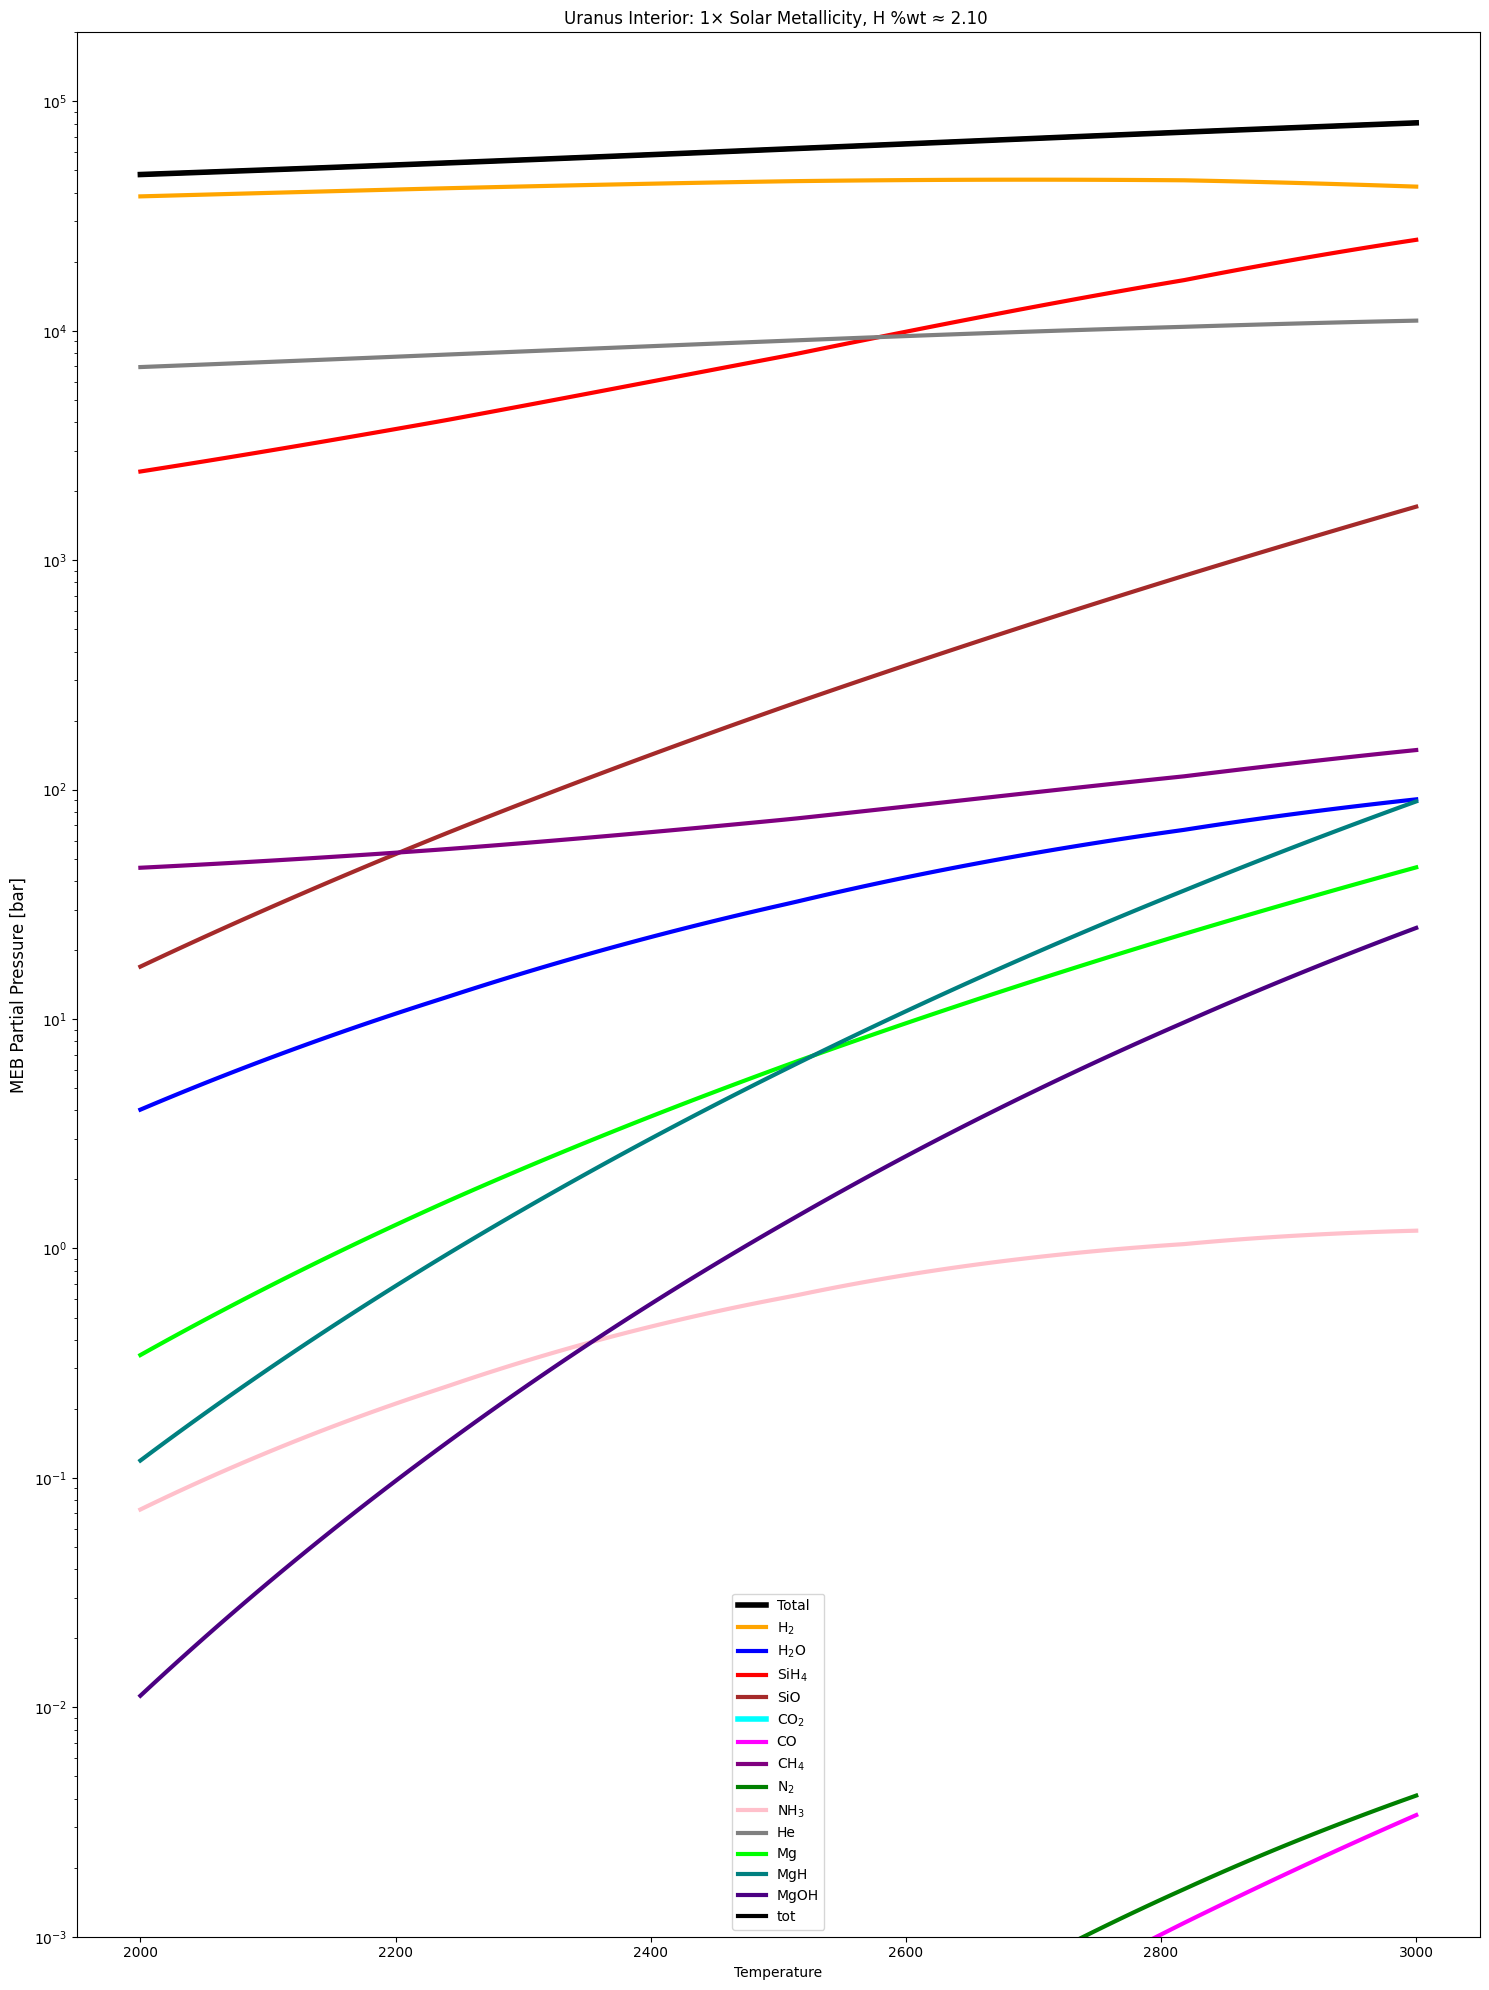

[10:44:46 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMgO_g: IdealGas, NoSolubility')
[10:44:46 - atmodeller.classes             - INFO     ] - reactions = {0: '1.0 H2_g + 1.0 CO2_g = 1.0 H2O_g + 1.0 CO_g',
 1: '4.0 H2_g + 1.0 CO2_g = 2.0 H2O_g + 1.0 CH4_g',
 2: '4.0 H2_g + 1.0 O2Si_l = 2.0 H2O_g + 1.0 H4Si_g',
 3: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 4: '2.0 H2O_g = 2.0 H2_g + 1.0 O2_g',
 5: '1.0 H2_g + 1.0 O2Si_l = 1.0 H2O_g + 1.0 OSi_g',
 6: '1.0 H2O_g + 1.0 Mg_g = 

3.24422607917163


[10:44:50 - atmodeller.output              - INFO     ] - Writing output to excel
[10:44:50 - atmodeller.output              - INFO     ] - Computing to_dataframes output
[10:44:50 - atmodeller.output              - INFO     ] - Computing asdict output
[10:44:55 - atmodeller.output              - INFO     ] - Output written to HHeCNOSi_magma_nosol_ideal.xlsx
[10:44:55 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, SolubilityPowerLaw', 'H2_g: IdealGas, SolubilityPowerLawLog10', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, _CO2_basalt_dixon95', 'CO_g: IdealGas, _CO_basalt_yoshioka19', 'CH4_g: IdealGas, _CH4_basalt_ardia13', 'N2_g: IdealGas, _N2_basalt_libourel03', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, SolubilityPowerLaw', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMg

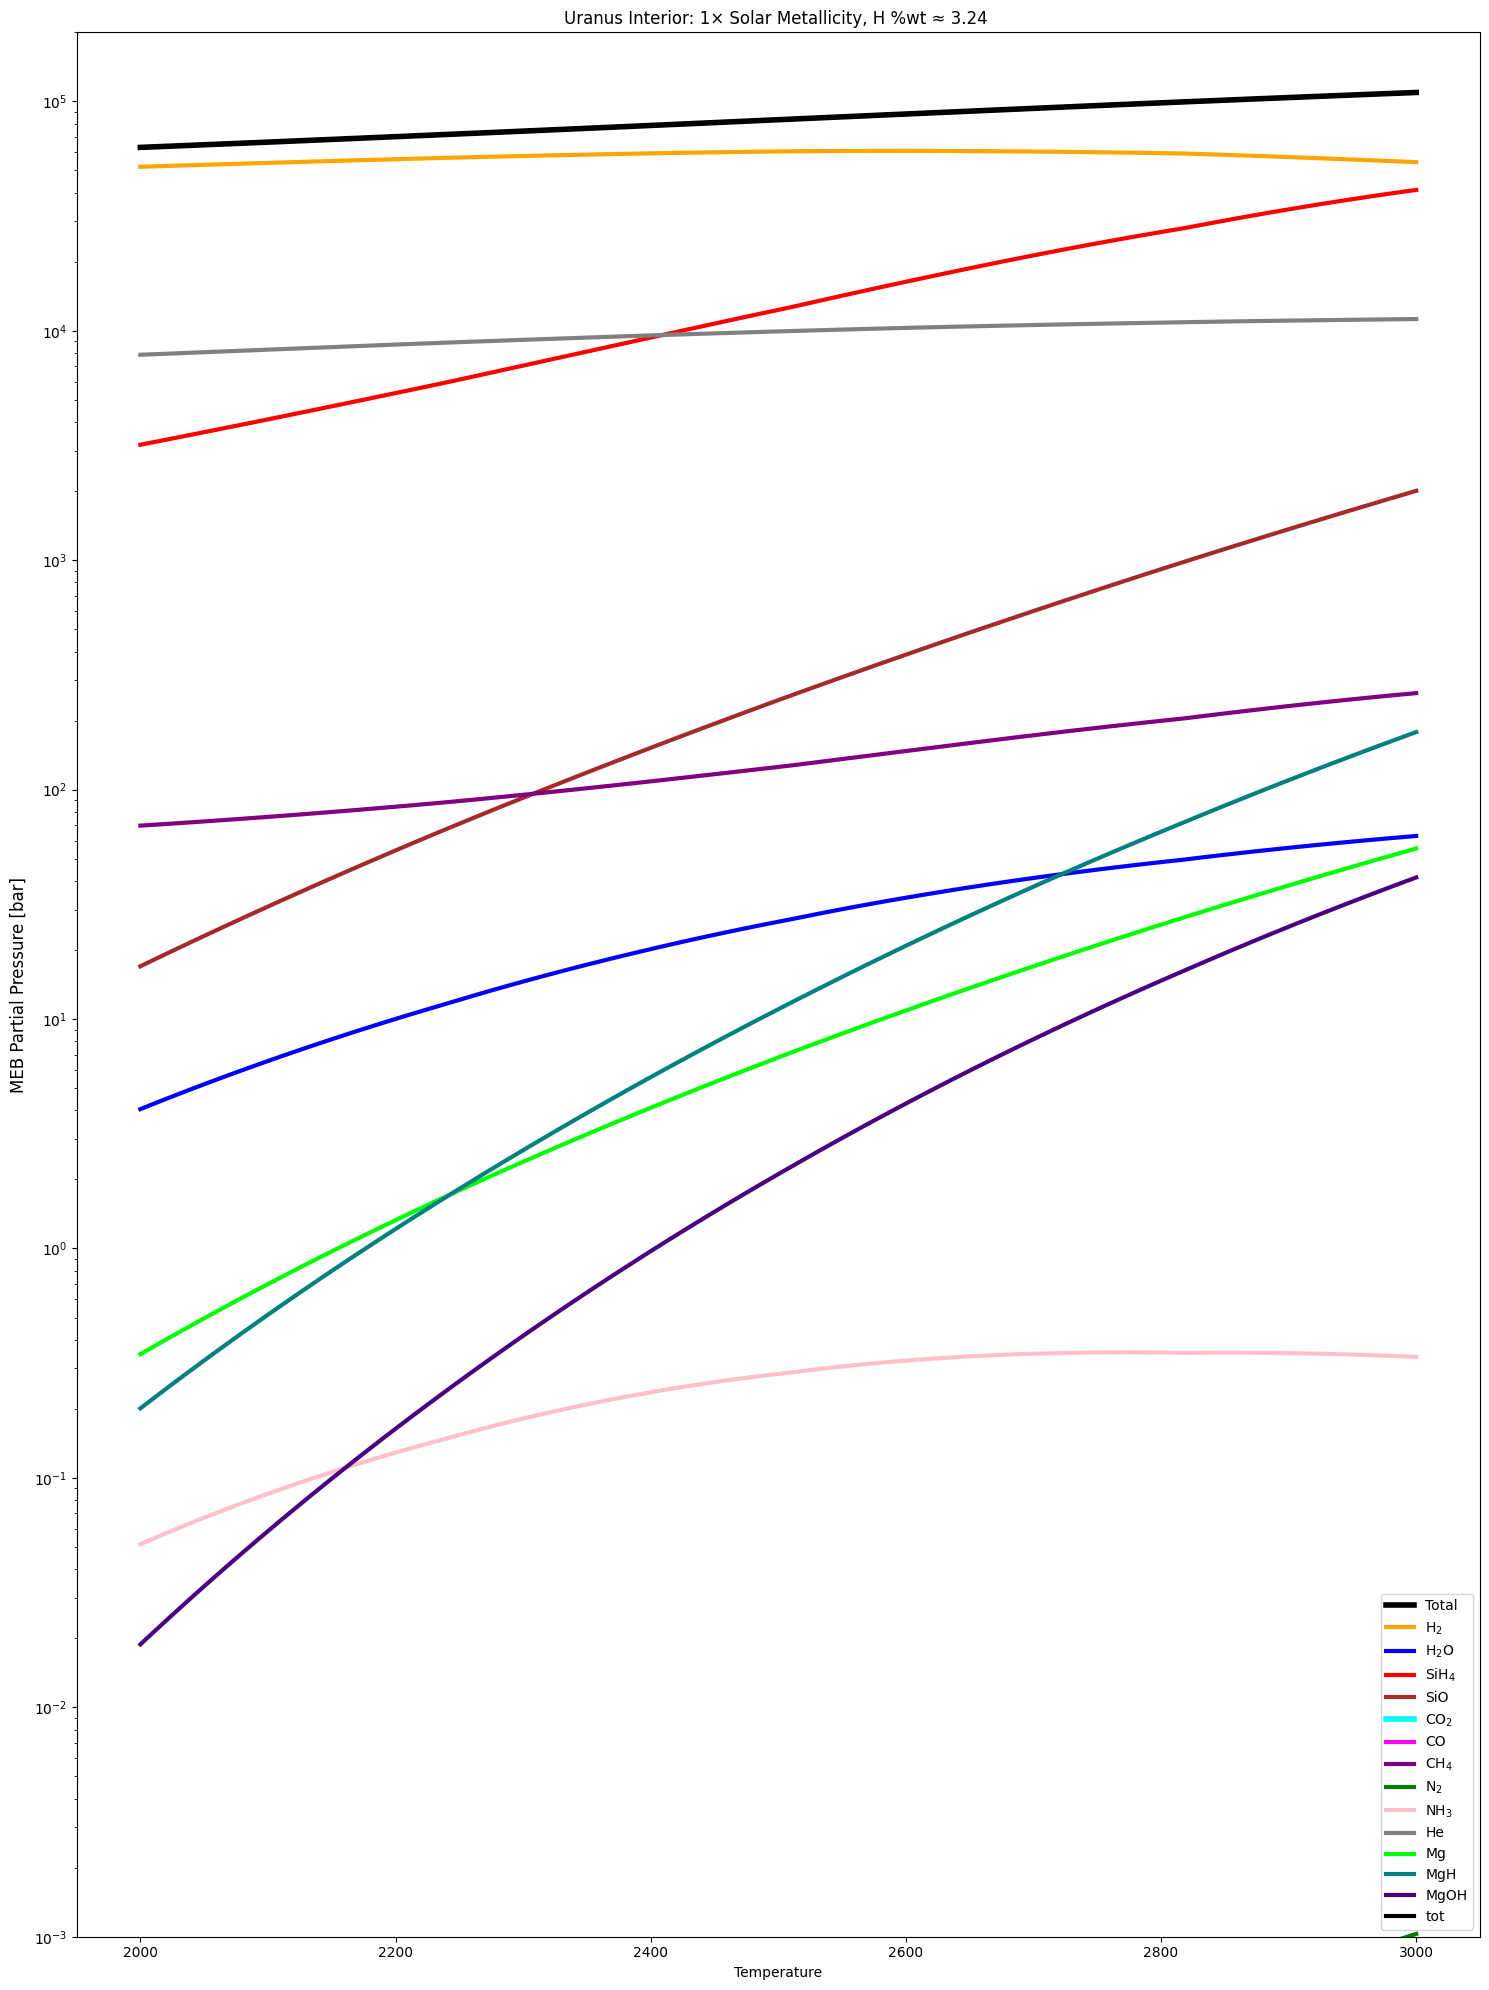

[10:45:20 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMgO_g: IdealGas, NoSolubility')
[10:45:20 - atmodeller.classes             - INFO     ] - reactions = {0: '1.0 H2_g + 1.0 CO2_g = 1.0 H2O_g + 1.0 CO_g',
 1: '4.0 H2_g + 1.0 CO2_g = 2.0 H2O_g + 1.0 CH4_g',
 2: '4.0 H2_g + 1.0 O2Si_l = 2.0 H2O_g + 1.0 H4Si_g',
 3: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 4: '2.0 H2O_g = 2.0 H2_g + 1.0 O2_g',
 5: '1.0 H2_g + 1.0 O2Si_l = 1.0 H2O_g + 1.0 OSi_g',
 6: '1.0 H2O_g + 1.0 Mg_g = 

5.011872336272722


[10:45:22 - atmodeller.output              - INFO     ] - Writing output to excel
[10:45:22 - atmodeller.output              - INFO     ] - Computing to_dataframes output
[10:45:22 - atmodeller.output              - INFO     ] - Computing asdict output
[10:45:27 - atmodeller.output              - INFO     ] - Output written to HHeCNOSi_magma_nosol_ideal.xlsx
[10:45:27 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, SolubilityPowerLaw', 'H2_g: IdealGas, SolubilityPowerLawLog10', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, _CO2_basalt_dixon95', 'CO_g: IdealGas, _CO_basalt_yoshioka19', 'CH4_g: IdealGas, _CH4_basalt_ardia13', 'N2_g: IdealGas, _N2_basalt_libourel03', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, SolubilityPowerLaw', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMg

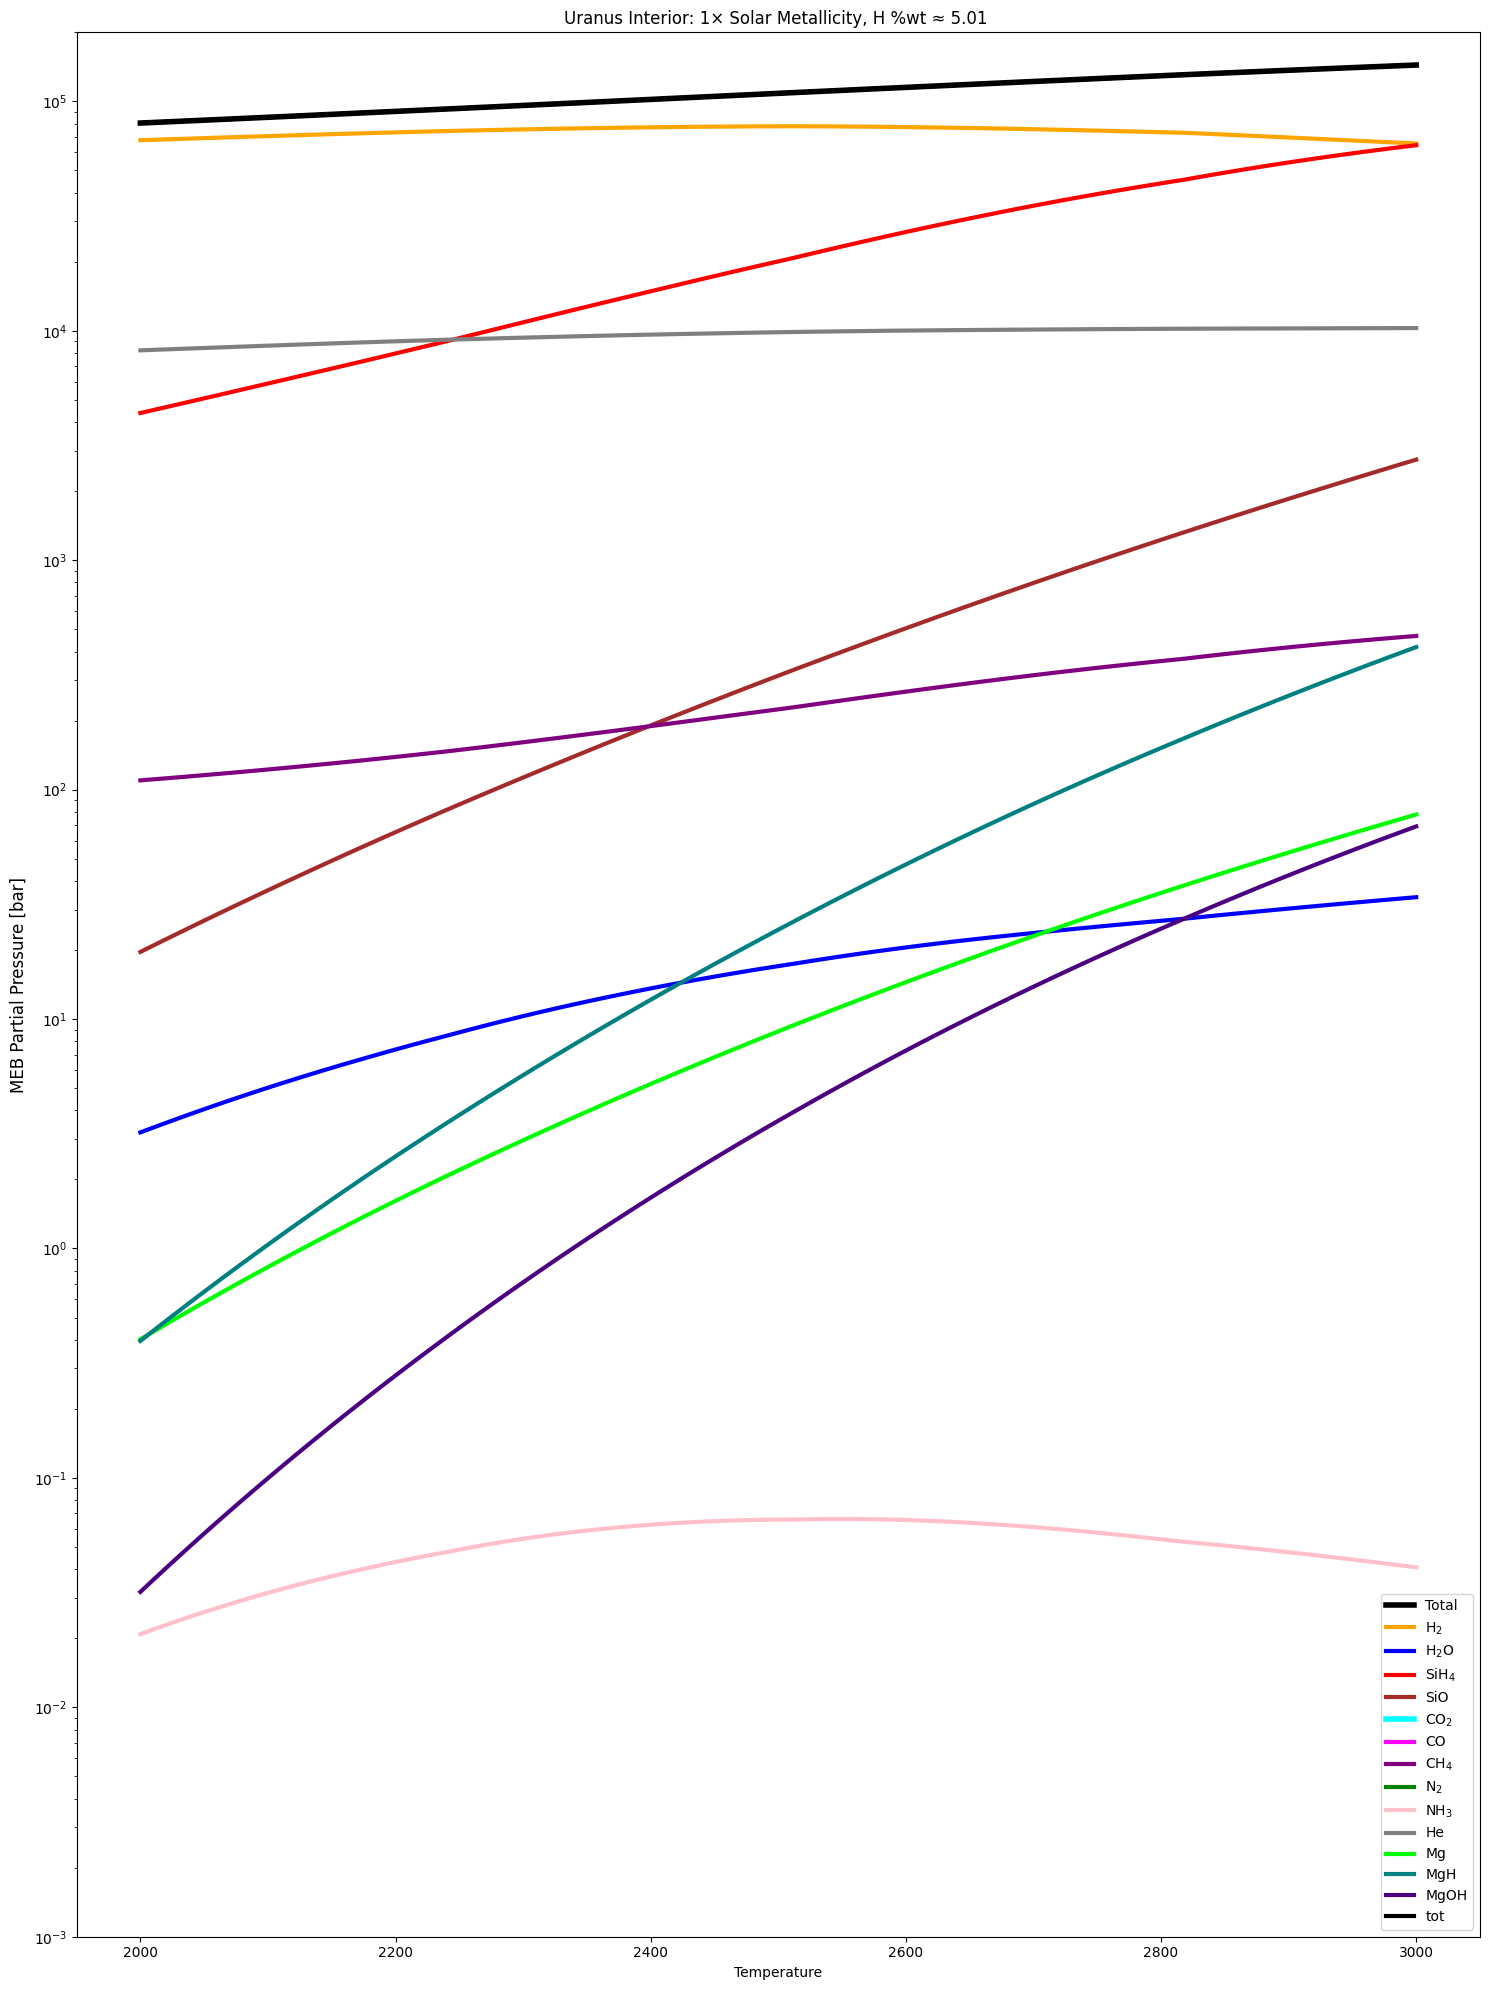

[10:45:55 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMgO_g: IdealGas, NoSolubility')
[10:45:55 - atmodeller.classes             - INFO     ] - reactions = {0: '1.0 H2_g + 1.0 CO2_g = 1.0 H2O_g + 1.0 CO_g',
 1: '4.0 H2_g + 1.0 CO2_g = 2.0 H2O_g + 1.0 CH4_g',
 2: '4.0 H2_g + 1.0 O2Si_l = 2.0 H2O_g + 1.0 H4Si_g',
 3: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 4: '2.0 H2O_g = 2.0 H2_g + 1.0 O2_g',
 5: '1.0 H2_g + 1.0 O2Si_l = 1.0 H2O_g + 1.0 OSi_g',
 6: '1.0 H2O_g + 1.0 Mg_g = 

0.1


[10:45:58 - atmodeller.output              - INFO     ] - Writing output to excel
[10:45:58 - atmodeller.output              - INFO     ] - Computing to_dataframes output
[10:45:58 - atmodeller.output              - INFO     ] - Computing asdict output
[10:46:03 - atmodeller.output              - INFO     ] - Output written to HHeCNOSi_magma_nosol_ideal.xlsx
[10:46:03 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, SolubilityPowerLaw', 'H2_g: IdealGas, SolubilityPowerLawLog10', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, _CO2_basalt_dixon95', 'CO_g: IdealGas, _CO_basalt_yoshioka19', 'CH4_g: IdealGas, _CH4_basalt_ardia13', 'N2_g: IdealGas, _N2_basalt_libourel03', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, SolubilityPowerLaw', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMg

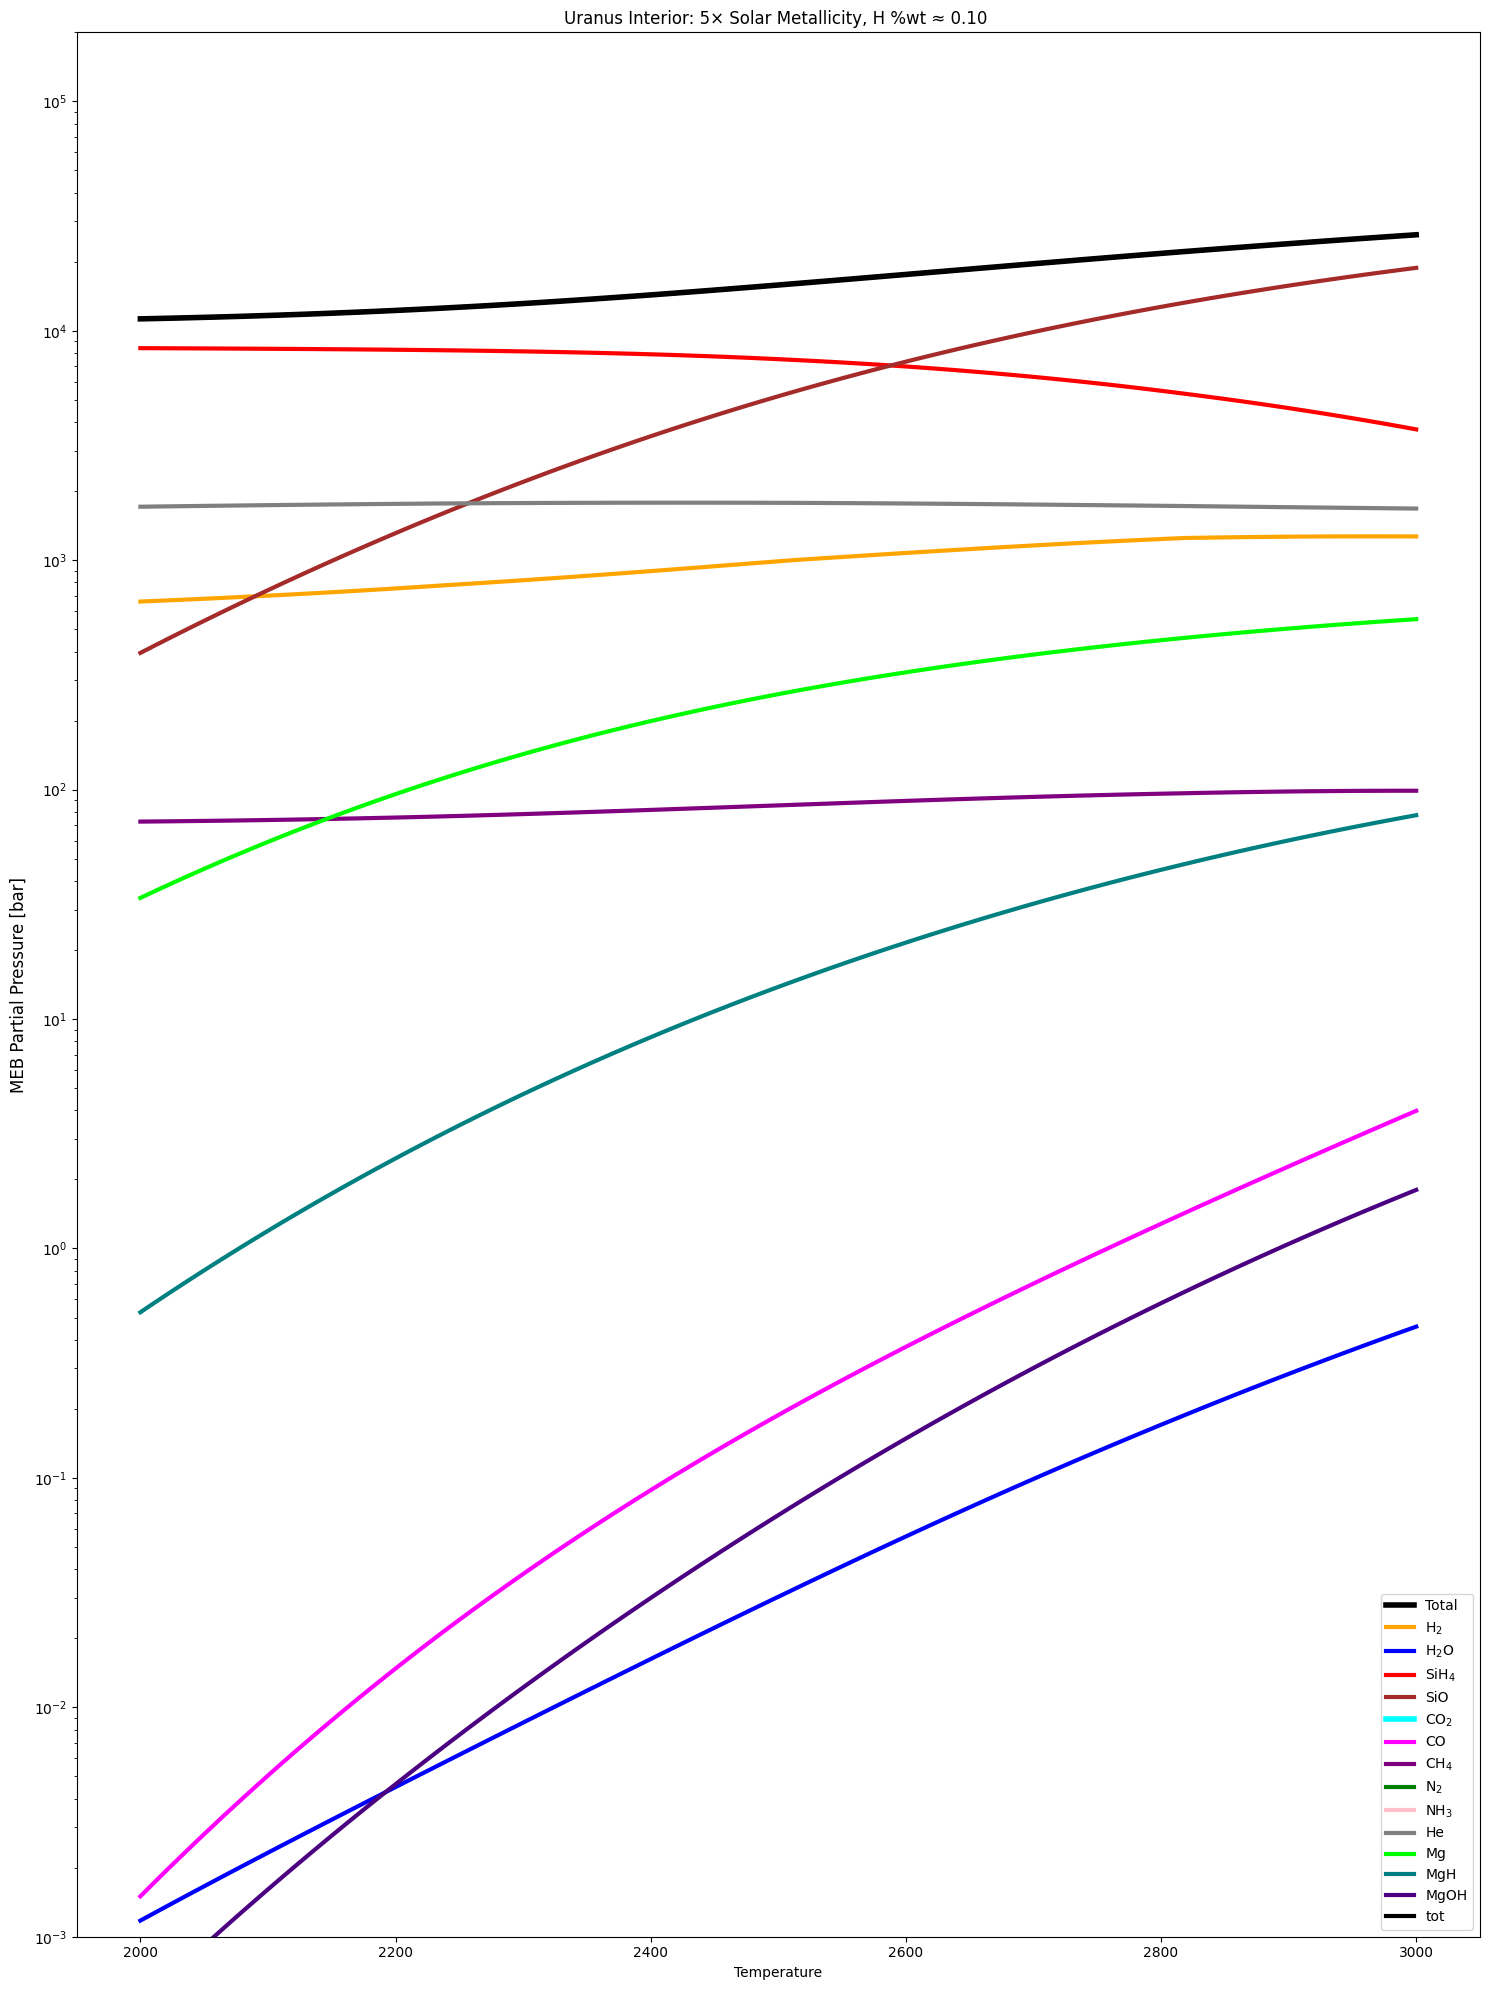

[10:46:29 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMgO_g: IdealGas, NoSolubility')
[10:46:29 - atmodeller.classes             - INFO     ] - reactions = {0: '1.0 H2_g + 1.0 CO2_g = 1.0 H2O_g + 1.0 CO_g',
 1: '4.0 H2_g + 1.0 CO2_g = 2.0 H2O_g + 1.0 CH4_g',
 2: '4.0 H2_g + 1.0 O2Si_l = 2.0 H2O_g + 1.0 H4Si_g',
 3: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 4: '2.0 H2O_g = 2.0 H2_g + 1.0 O2_g',
 5: '1.0 H2_g + 1.0 O2Si_l = 1.0 H2O_g + 1.0 OSi_g',
 6: '1.0 H2O_g + 1.0 Mg_g = 

0.15448591479026755


[10:46:30 - atmodeller.classes             - WARNING  ] - 7 model(s) failed to converge on the first attempt
[10:46:30 - atmodeller.classes             - WARNING  ] - But don't panic! This can happen when starting from a poor initial guess.
[10:46:30 - atmodeller.classes             - WARNING  ] - Launching multistart (maximum 10 attempts)
[10:46:30 - atmodeller.classes             - WARNING  ] - Attempting to solve the 7 models(s) that initially failed
[10:46:30 - atmodeller.classes             - INFO     ] - Multistart with species' stability (TAU_MAX= 1.0e-03, TAU= 1.0e-25, TAU_NUM= 2)
[10:46:37 - atmodeller.classes             - INFO     ] - Multistart complete with 1 total attempt(s)
[10:46:37 - atmodeller.classes             - INFO     ] - Multistart, max attempts: 1, model count: 100 (100.00%)
[10:46:37 - atmodeller.classes             - INFO     ] - Solve complete: 100 (100.00%) successful model(s)
[10:46:37 - atmodeller.classes             - INFO     ] - Solver steps (max) = 1

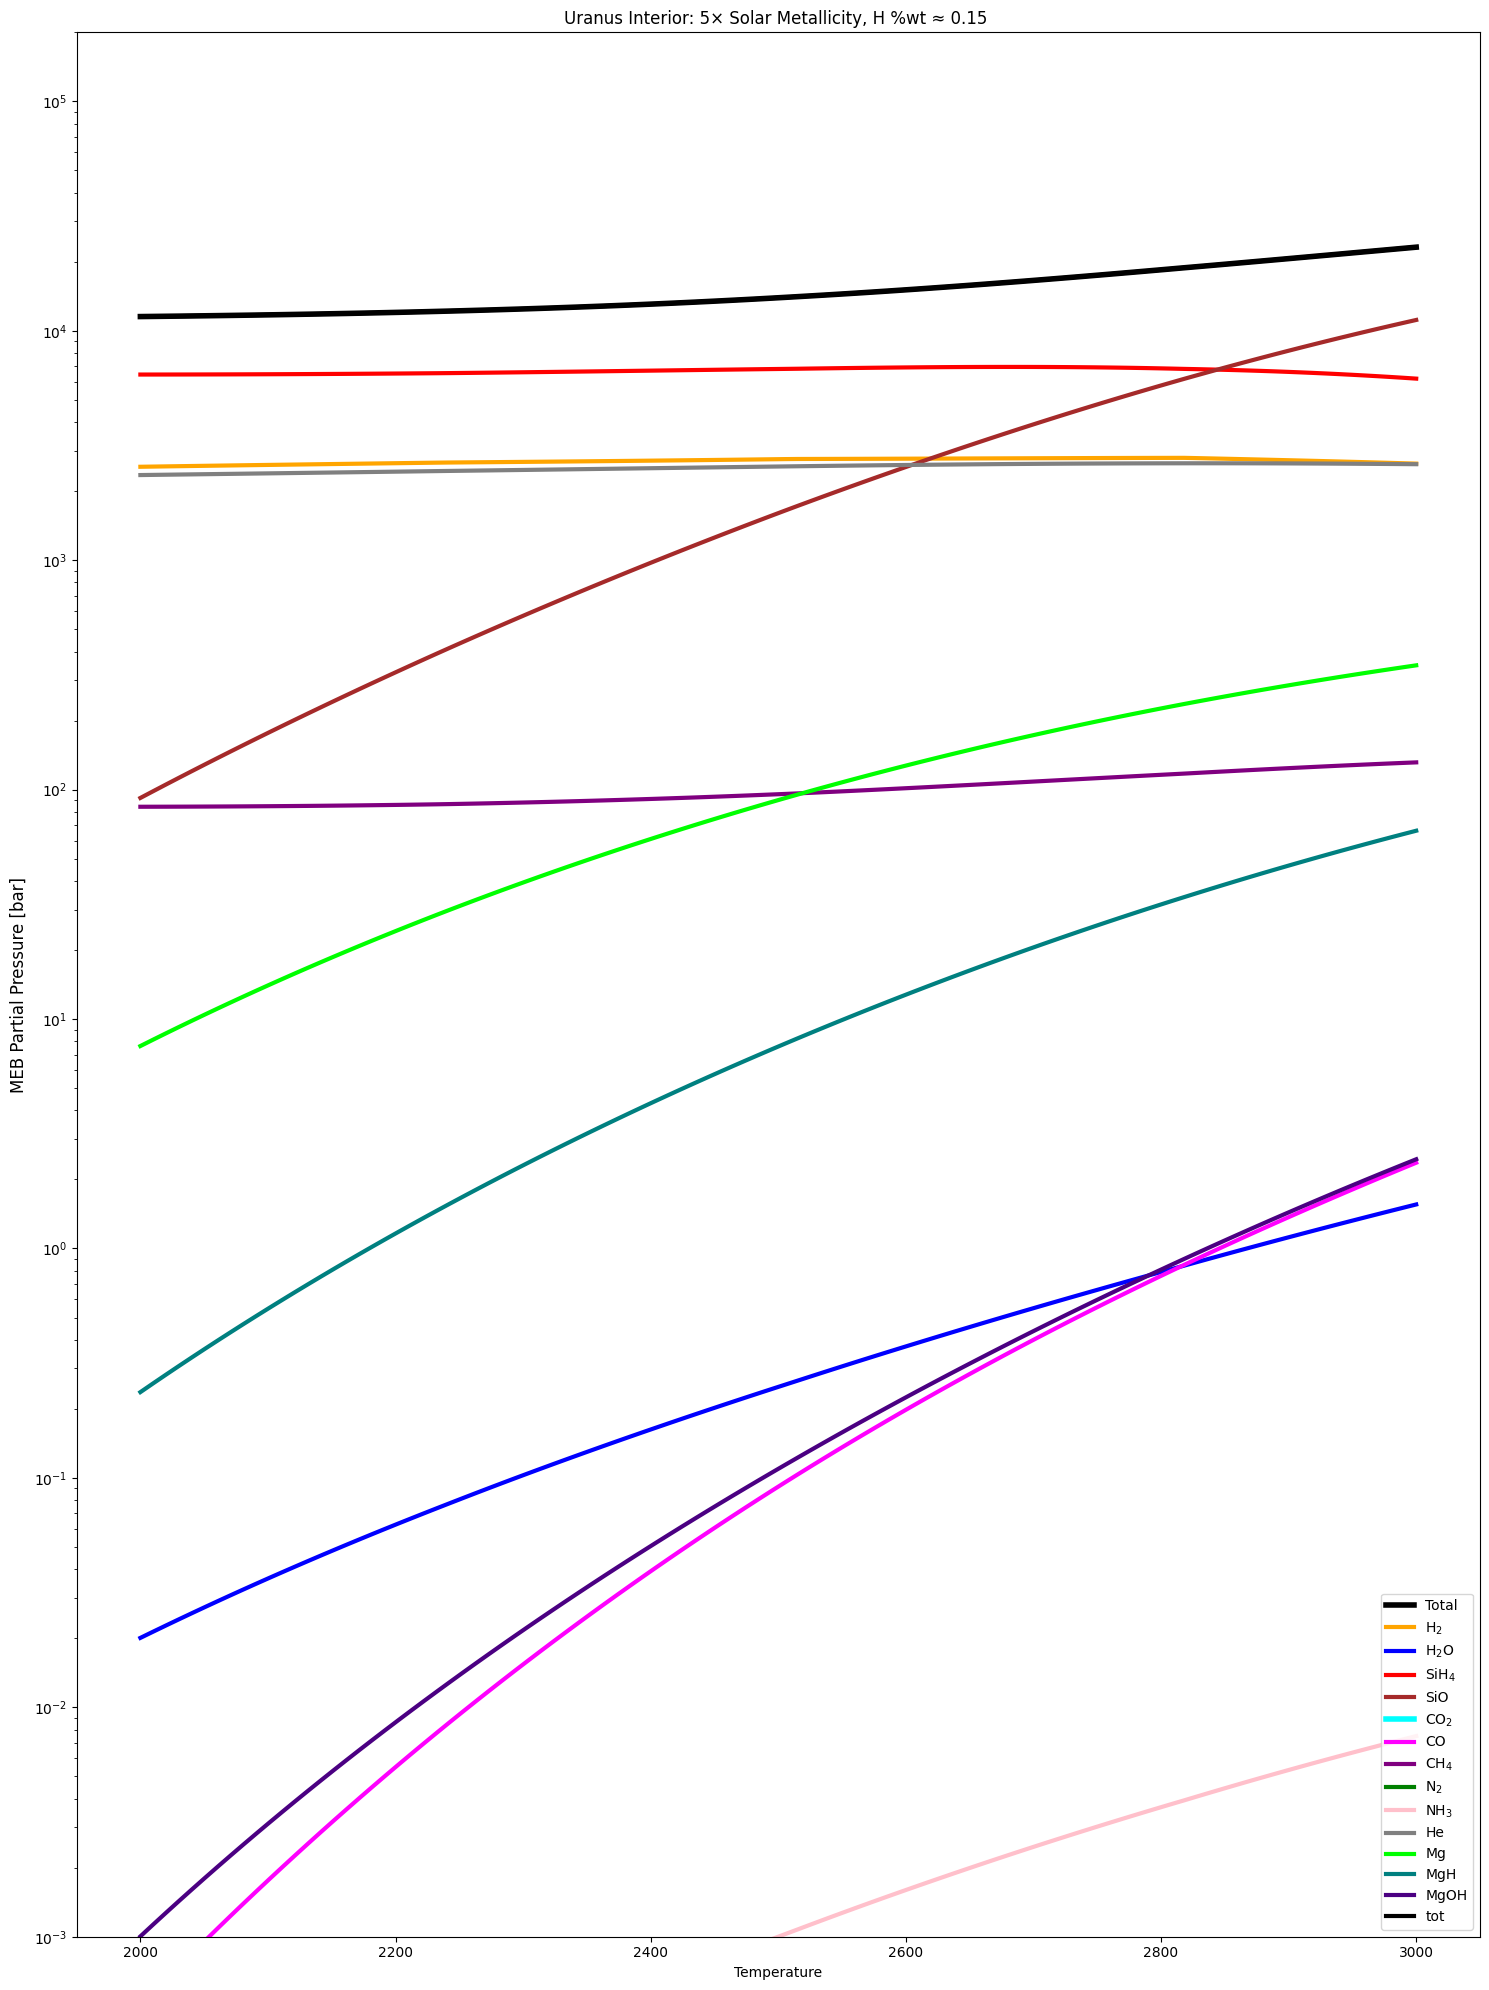

[10:47:10 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMgO_g: IdealGas, NoSolubility')
[10:47:10 - atmodeller.classes             - INFO     ] - reactions = {0: '1.0 H2_g + 1.0 CO2_g = 1.0 H2O_g + 1.0 CO_g',
 1: '4.0 H2_g + 1.0 CO2_g = 2.0 H2O_g + 1.0 CH4_g',
 2: '4.0 H2_g + 1.0 O2Si_l = 2.0 H2O_g + 1.0 H4Si_g',
 3: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 4: '2.0 H2O_g = 2.0 H2_g + 1.0 O2_g',
 5: '1.0 H2_g + 1.0 O2Si_l = 1.0 H2O_g + 1.0 OSi_g',
 6: '1.0 H2O_g + 1.0 Mg_g = 

0.2386589786858581


[10:47:11 - atmodeller.classes             - WARNING  ] - 4 model(s) failed to converge on the first attempt
[10:47:11 - atmodeller.classes             - WARNING  ] - But don't panic! This can happen when starting from a poor initial guess.
[10:47:11 - atmodeller.classes             - WARNING  ] - Launching multistart (maximum 10 attempts)
[10:47:11 - atmodeller.classes             - WARNING  ] - Attempting to solve the 4 models(s) that initially failed
[10:47:11 - atmodeller.classes             - INFO     ] - Multistart with species' stability (TAU_MAX= 1.0e-03, TAU= 1.0e-25, TAU_NUM= 2)
[10:47:18 - atmodeller.classes             - INFO     ] - Multistart complete with 1 total attempt(s)
[10:47:18 - atmodeller.classes             - INFO     ] - Multistart, max attempts: 1, model count: 100 (100.00%)
[10:47:18 - atmodeller.classes             - INFO     ] - Solve complete: 100 (100.00%) successful model(s)
[10:47:18 - atmodeller.classes             - INFO     ] - Solver steps (max) = 1

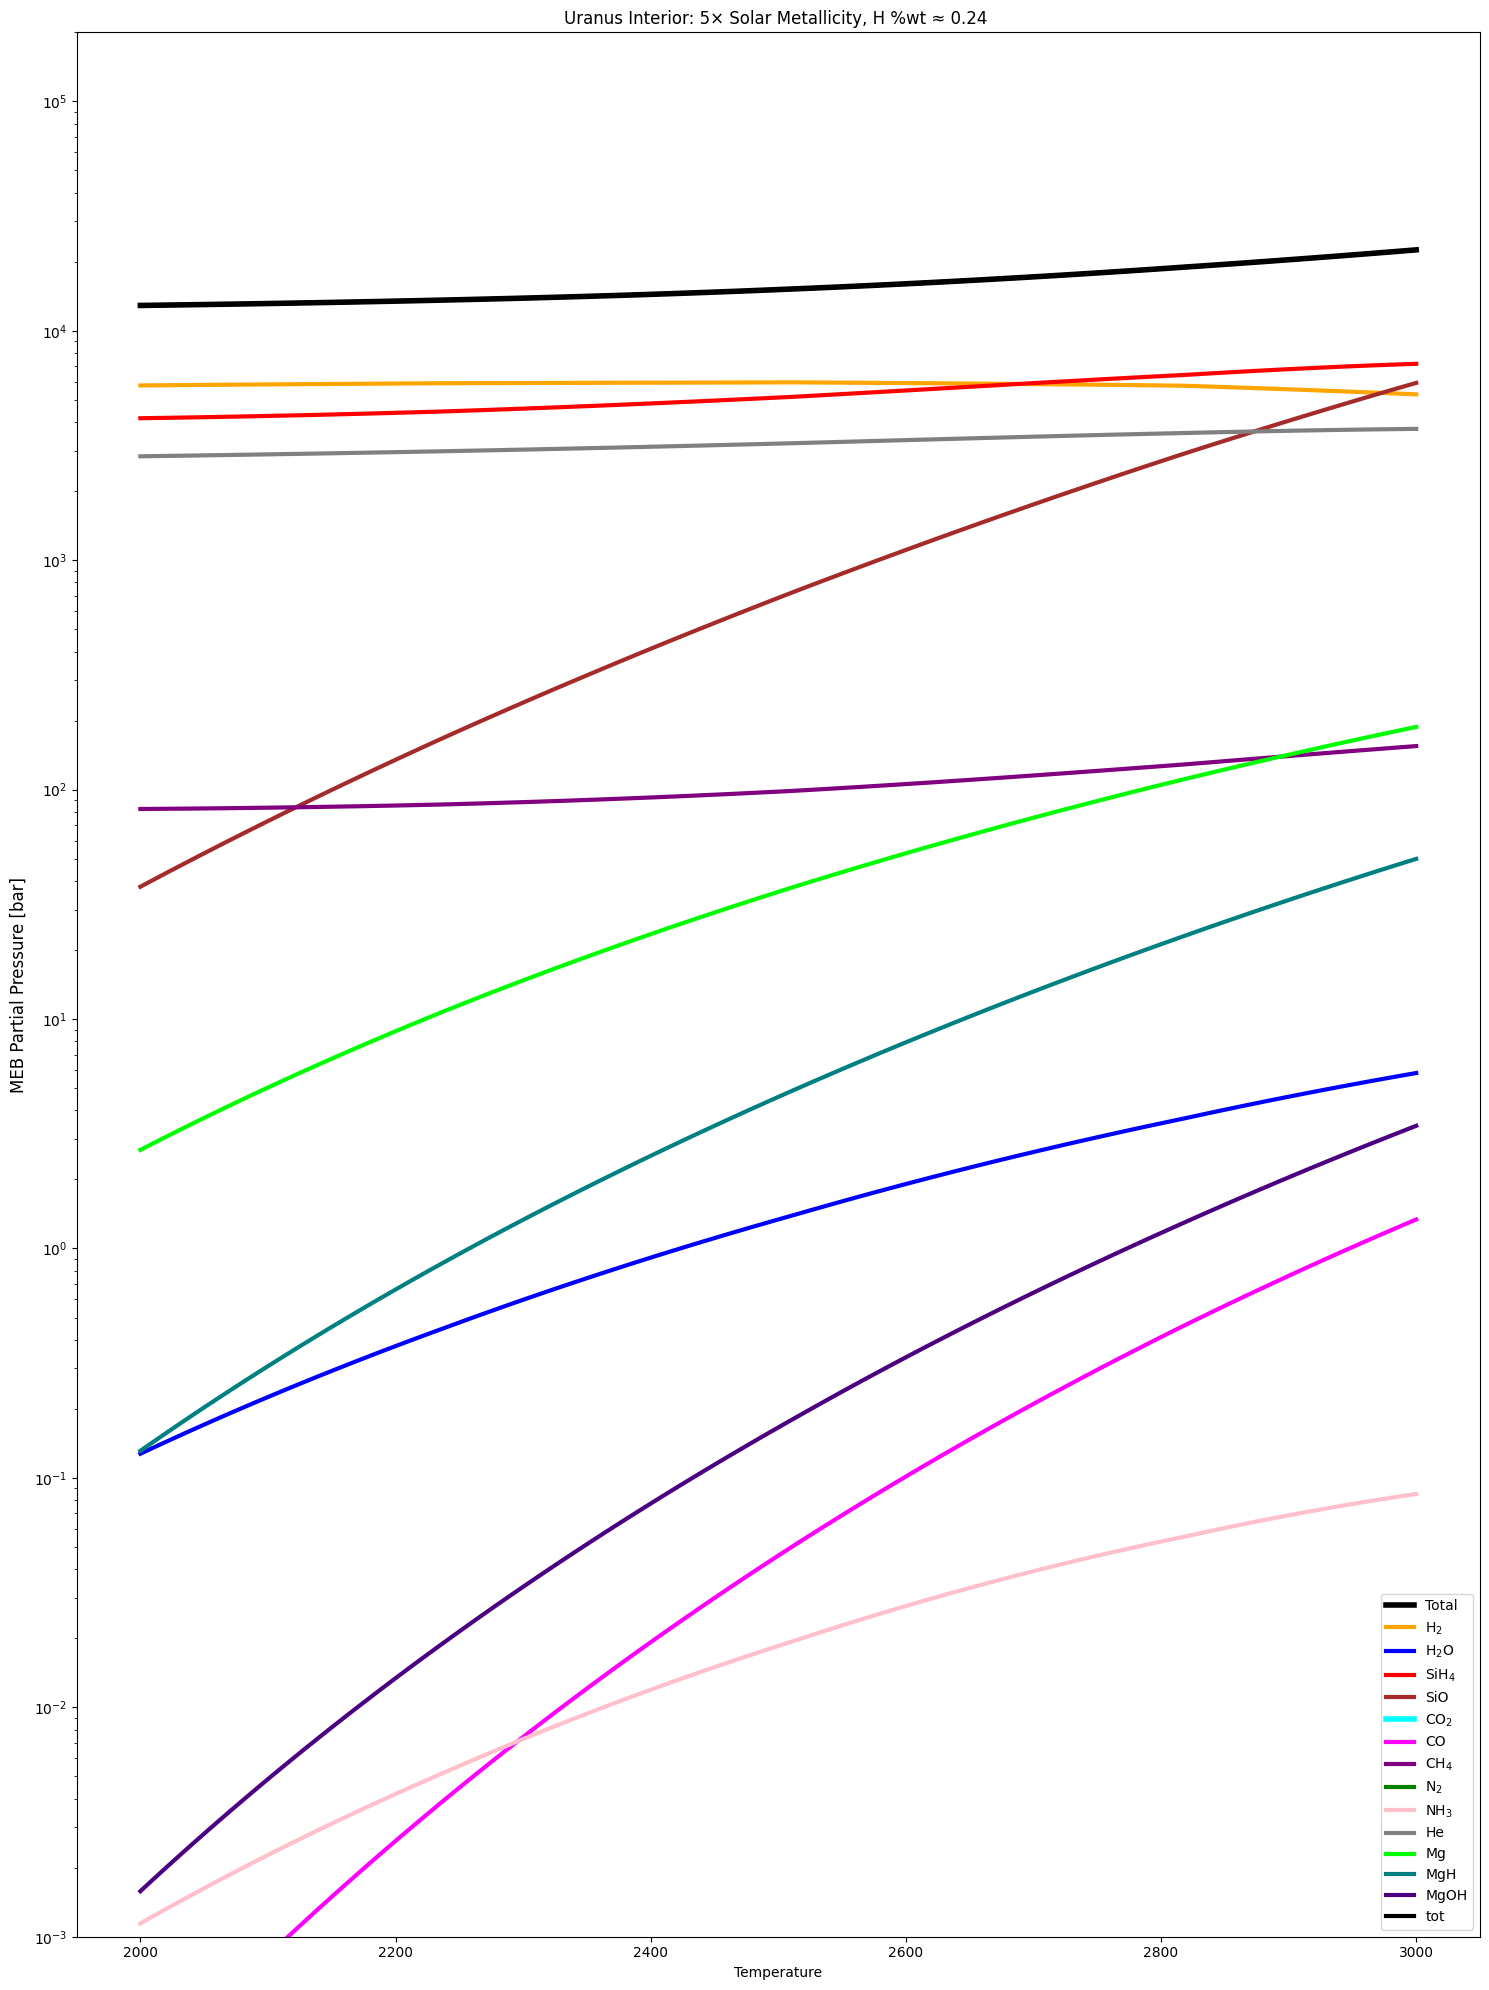

[10:47:54 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMgO_g: IdealGas, NoSolubility')
[10:47:54 - atmodeller.classes             - INFO     ] - reactions = {0: '1.0 H2_g + 1.0 CO2_g = 1.0 H2O_g + 1.0 CO_g',
 1: '4.0 H2_g + 1.0 CO2_g = 2.0 H2O_g + 1.0 CH4_g',
 2: '4.0 H2_g + 1.0 O2Si_l = 2.0 H2O_g + 1.0 H4Si_g',
 3: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 4: '2.0 H2O_g = 2.0 H2_g + 1.0 O2_g',
 5: '1.0 H2_g + 1.0 O2Si_l = 1.0 H2O_g + 1.0 OSi_g',
 6: '1.0 H2O_g + 1.0 Mg_g = 

0.3686945064519575


[10:47:56 - atmodeller.output              - INFO     ] - Writing output to excel
[10:47:56 - atmodeller.output              - INFO     ] - Computing to_dataframes output
[10:47:56 - atmodeller.output              - INFO     ] - Computing asdict output
[10:48:00 - atmodeller.output              - INFO     ] - Output written to HHeCNOSi_magma_nosol_ideal.xlsx
[10:48:00 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, SolubilityPowerLaw', 'H2_g: IdealGas, SolubilityPowerLawLog10', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, _CO2_basalt_dixon95', 'CO_g: IdealGas, _CO_basalt_yoshioka19', 'CH4_g: IdealGas, _CH4_basalt_ardia13', 'N2_g: IdealGas, _N2_basalt_libourel03', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, SolubilityPowerLaw', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMg

KeyboardInterrupt: 

KeyboardInterrupt: 

In [18]:
init_metallicity = [5,10]
for metall in init_metallicity:
    for perc in hmps:
        print(perc)
        h_kgs = perc / 100 * planet_mass  # kg

        si_kg_magma: float = Si_massfraction_palme14 * planet_mass
        mg_kg_magma: float = Mg_massfraction_palme14 * planet_mass
        o_kg_magma: float = O_massfraction_palme14 * planet_mass

        # Lodders et al. (2009) Springer book chapter Table 8
        si_kgs_solar = h_kgs * Si_masspercent_lodders09 / H_masspercent_lodders09
        mg_kgs_solar = h_kgs * Mg_masspercent_lodders09 / H_masspercent_lodders09
        o_kgs_solar = h_kgs * O_masspercent_lodders09 / H_masspercent_lodders09
        c_kgs_solar = h_kgs * C_masspercent_lodders09 / H_masspercent_lodders09
        n_kgs_solar = h_kgs * N_masspercent_lodders09 / H_masspercent_lodders09
        he_kgs_solar = h_kgs * He_masspercent_lodders09 / H_masspercent_lodders09
        mass_constraints = {
            "H": h_kgs,
            "He": he_kgs_solar,
            "C": metall * c_kgs_solar,
            "N": metall * n_kgs_solar,
            "Si": metall * si_kgs_solar + mantle_melt_fraction * si_kg_magma,
            "O": metall * o_kgs_solar + mantle_melt_fraction * o_kg_magma,
            "Mg": metall * mg_kgs_solar + mantle_melt_fraction * mg_kg_magma,
                }

        Uranus = Planet(
            surface_temperature=temperature,
            planet_mass=planet_mass,
            mantle_melt_fraction=mantle_melt_fraction,
            surface_radius=boundary_radius,
            )

        model_magma_nosol_ideal = InteriorAtmosphere(species_HHeCNOSi_magma_nosol_ideal)
        model_magma_nosol_ideal.solve(
                planet=Uranus,
                mass_constraints=mass_constraints,
                )
        output_magma_nosol_ideal = model_magma_nosol_ideal.output
        output_magma_nosol_ideal.quick_look()
        output_magma_nosol_ideal.to_excel("HHeCNOSi_magma_nosol_ideal")

        model_magma_sol_ideal = InteriorAtmosphere(species_HHeCNOSi_magma_sol_ideal)
        initial_log_number_density = output_magma_nosol_ideal.log_number_density
        model_magma_sol_ideal.solve(
                planet=Uranus,
                mass_constraints=mass_constraints,
                initial_log_number_density=initial_log_number_density,
                )
        output_magma_sol_ideal = model_magma_sol_ideal.output
        output_magma_sol_ideal.quick_look()
        output_magma_sol_ideal.to_excel("HHeCNOSi_magma_sol_ideal")

        model_magma_sol_real = InteriorAtmosphere(species_HHeCNOSi_magma_sol_real)
        initial_log_number_density = output_magma_sol_ideal.log_number_density
        model_magma_sol_real.solve(
                planet=Uranus,
                mass_constraints=mass_constraints,
                initial_log_number_density=initial_log_number_density,
                )
        output_magma_sol_real = model_magma_sol_real.output
        output_magma_sol_real.quick_look()
        output_magma_sol_real.to_excel("HHeCNOSi_magma_sol_real")

        filename = "HHeCNOSi_magma_sol_real.xlsx"
        
        H2_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H2_g")["pressure"]
        H2O_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H2O_g")["pressure"]
        O2_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="O2_g")["pressure"]
        SiH4_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H4Si_g")["pressure"]
        SiO_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="OSi_g")["pressure"]
        CO2_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="CO2_g")["pressure"]
        CO_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="CO_g")["pressure"]
        CH4_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="CH4_g")["pressure"]
        N2_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="N2_g")["pressure"]
        NH3_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H3N_g")["pressure"]
        He_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="He_g")["pressure"]
        Mg_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="Mg_g")["pressure"]
        MgOH_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="HMgO_g")["pressure"]
        MgH_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="HMg_g")["pressure"]
        tot_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

        fig, axes = plt.subplots(1, 1, figsize=(15, 20))

        axes.plot(temperature, tot_pressure_magma_sol_real, color=color_tot, lw=4, ls="-", label="Total")
        axes.plot(temperature, H2_pressure_magma_sol_real, color=color_H2, lw=3, ls="-", label="H$_2$")
        axes.plot(temperature, H2O_pressure_magma_sol_real, color=color_H2O, lw=3, ls="-", label="H$_2$O")
        axes.plot(temperature, SiH4_pressure_magma_sol_real, color=color_SiH4, lw=3, ls="-", label="SiH$_4$")
        axes.plot(temperature, SiO_pressure_magma_sol_real, color=color_SiO, lw=3, ls="-", label="SiO")
        axes.plot(temperature, CO2_pressure_magma_sol_real, color=color_CO2, lw=4, ls="-", label="CO$_2$")
        axes.plot(temperature, CO_pressure_magma_sol_real, color=color_CO, lw=3, ls="-", label="CO")
        axes.plot(temperature, CH4_pressure_magma_sol_real, color=color_CH4, lw=3, ls="-", label="CH$_4$")
        axes.plot(temperature, N2_pressure_magma_sol_real, color=color_N2, lw=3, ls="-", label="N$_2$")
        axes.plot(temperature, NH3_pressure_magma_sol_real, color=color_NH3, lw=3, ls="-", label="NH$_3$")
        axes.plot(temperature, He_pressure_magma_sol_real, color=color_He, lw=3, ls="-", label="He")
        axes.plot(temperature, Mg_pressure_magma_sol_real, color=color_Mg, lw=3, ls="-", label="Mg")
        axes.plot(temperature, MgH_pressure_magma_sol_real, color=color_MgH, lw=3, ls="-", label="MgH")
        axes.plot(temperature, MgOH_pressure_magma_sol_real, color=color_MgOH, lw=3, ls="-", label="MgOH")
        axes.plot(temperature, tot_pressure_magma_sol_real, color=color_tot, lw=3, ls="-", label="tot")

        axes.set_title(r"(a) Real gas")
        axes.set_ylim([1e-3, 2e5])
        axes.set_yscale("log")
        axes.set_xlabel(r"Temperature", fontsize=10)
        axes.set_ylabel(r"MEB Partial Pressure [bar]", fontsize=12)
        axes.get_xaxis().set_major_formatter(ScalarFormatter())

        axes.legend(fontsize=10, loc='best') 
        
        plt.tight_layout()
        title = f"Uranus Interior: {metall:.0f}× Solar Metallicity, H %wt ≈ {perc:.2f} "
        filename = f"./images_pressures2/uranus_{metall:.0f}xperc_{perc:.2f}.png"

        plt.title(title)
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()